In [1]:
import numpy as np

import pandas as pd

# used to grab the stock prices, with yahoo

import pandas_datareader as web

from datetime import datetime
from dateutil.relativedelta import relativedelta

# to visualize the results

import matplotlib.pyplot as plt

import seaborn

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import os
import re
from time import sleep

In [2]:
# STEP 1: Load stock screener data from nasdaq.
# The stock screener is a csv file downloaded from the nasdaq website and contains information (Symbol, market cap,
# sectors, industries and more) about different stocks.



chromeOptions = webdriver.ChromeOptions()
cur_dir = os.getcwd()
prefs = {"download.default_directory" : cur_dir}
chromeOptions.add_experimental_option("prefs",prefs)

driver = webdriver.Chrome(executable_path=ChromeDriverManager().install(), chrome_options=chromeOptions)
driver.get("https://www.nasdaq.com/market-activity/stocks/screener")

driver.implicitly_wait(5)
link = driver.find_element_by_class_name("nasdaq-screener__download")
link.click()


file_location = os.path.join(cur_dir, 'nasdaq_screener.csv')

if os.path.isfile(file_location):
    os.remove(file_location) # delete if previous file exists

# delete suffix from the csv file's name
file_regex = re.compile('nasdaq_screener_\d+\.csv')

sleep(15)

while not os.path.isfile(file_location):
    for root, dirs, files in os.walk(cur_dir):
        for f in files:
            if file_regex.match(f):
                os.rename(f, 'nasdaq_screener.csv')
                break


driver.close()



====== WebDriver manager ======
Current google-chrome version is 98.0.4758
Get LATEST chromedriver version for 98.0.4758 google-chrome
Driver [/Users/nadavsmacbookpro/.wdm/drivers/chromedriver/mac64/98.0.4758.102/chromedriver] found in cache
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  app.launch_new_instance()


In [120]:
# Get tickers from csv to pandas

stocks_screener = pd.read_csv('nasdaq_screener.csv')
stocks_screener = stocks_screener.sort_values(by='Market Cap', ascending=False)
stocks_screener["IPO Year"].fillna(2022, inplace=True)
stocks_screener = stocks_screener.drop(stocks_screener[stocks_screener["IPO Year"] >= 2021].index)

stocks_screener["Sector"].fillna('undefined', inplace=True)
stocks_screener["Industry"].fillna('undefined', inplace=True)
stocks_screener



Symbol                                               Name Last Sale  \
19     AAPL                            Apple Inc. Common Stock   $164.85   
5126   MSFT                 Microsoft Corporation Common Stock   $297.31   
3437   GOOG                Alphabet Inc. Class C Capital Stock  $2690.39   
477    AMZN                       Amazon.com Inc. Common Stock  $3075.77   
7685   TSLA                            Tesla Inc. Common Stock   $809.87   
...     ...                                                ...       ...   
2684  ESSCR           East Stone Acquisition Corporation Right     $0.38   
2580    ENO  Entergy New Orleans LLC First Mortgage Bonds 5...    $25.18   
2534  ELMSW          Electric Last Mile Solutions Inc. Warrant     $0.25   
2559    EMP  Entergy Mississippi LLC First Mortgage Bonds 4...    $25.13   
2563   ENBA  Enbridge Inc 6.375% Fixed-to-Floating Rate Sub...    $26.39   

      Net Change  % Change    Market Cap        Country  IPO Year    Volume  \
19        2.1100    1.297%  2.858060e+12  United States    1980.0  91878387   
5126      2.7200    0.923%  2.228893e+12  United States    1986.0  32528003   
3437     36.9200    1.391%  1.778271e+12  United States    2004.0   1311053   
477      48.6100    1.606%  1.565088e+12  United States    1997.0   3116733   
7685      9.1000    1.136%  8.370068e+11  United States    2010.0  25308170   
...          ...       ...           ...            ...       ...       ...   
2684      0.0098    2.647%  0.000000e+00  United States    2020.0     11223   
2580      0.0300    0.119%  0.000000e+00  United States    2016.0      2454   
2534     -0.0444  -15.082%  0.000000e+00  United States    2020.0      7803   
2559      0.0600    0.239%  0.000000e+00  United States    2016.0     41950   
2563     -0.0200   -0.076%  0.000000e+00         Canada    2018.0     17267   

                 Sector                                 Industry  
19           Technology                   Computer Manufacturing  
5126         Technology  Computer Software: Prepackaged Software  
3437         Technology        Internet and Information Services  
477   Consumer Services           Catalog/Specialty Distribution  
7685      Capital Goods                       Auto Manufacturing  
...                 ...                                      ...  
2684            Finance                        Business Services  
2580          undefined                                undefined  
2534      Capital Goods                       Auto Manufacturing  
2559          undefined                                undefined  
2563             Energy                     Oil & Gas Production  

[3101 rows x 11 columns]

In [3]:
# Load N_STOCKS from each sector
N_STOCKS = 50

sectors_set = set(stocks_screener["Sector"])
sectors_dict = {sector: list(stocks_screener.loc[stocks_screener["Sector"] == sector]["Symbol"][:N_STOCKS])
                for sector in sectors_set}

In [4]:
seaborn.set(rc={"figure.dpi":300, 'savefig.dpi':300})

# select start date for correlation window as well as list of tickers

# start = datetime.today() + relativedelta(months=-12)

# symbols_list = list(stocks_screener['Symbol'][:50])
# symbols= dict()

In [105]:
# pull price using iex for each symbol in list defined above
start = datetime.today() + relativedelta(months=-12)
end = datetime.today() + relativedelta(days=-5)
sectors_df = {sector: list() for sector in sectors_set}
for key, value in sectors_dict.items():
    print(f"######### {key} #########\n")
    if len(value) == 0:
        continue
    dates = set()
    for ticker in value:
        r = web.DataReader(ticker, 'yahoo', start, end)
        if len(r.index) < 200:
            continue

        if len(dates) == 0:
            dates = set(r.index)
        else:
            dates = dates.intersection(set(r.index))

        # add a symbol column
        r['Symbol'] = ticker
        r['Industry'] = list(stocks_screener.loc[stocks_screener["Symbol"] == ticker]['Industry'])[0]

        sectors_df[key].append(r)
    sectors_df[key] = pd.concat(sectors_df[key])
    sectors_df[key] = sectors_df[key].loc[list(dates)]


######### Consumer Durables #########

######### Technology #########

######### Capital Goods #########

######### Consumer Services #########

######### undefined #########

######### Public Utilities #########

######### Basic Industries #########

######### Health Care #########



KeyError: 'Date'

In [57]:
# todo - delete

# save data
for sector in sectors_set:
    sectors_df[sector].to_csv(f'backup/{sector}.csv')

In [5]:
#todo - delete

# load data
sectors_df = {sector: pd.read_csv(f'backup/{sector}.csv') for sector in sectors_set}

In [6]:
from collections import OrderedDict
dataframes = {sector: None for sector in sectors_set}
# concatenate into df
counter = 0
x = None
for sector in sectors_set:
    if len(sectors_df[sector]) == 0:
        continue

    df = sectors_df[sector].sort_values(by='Industry')
    order = list(OrderedDict.fromkeys(df['Symbol'].tolist()))

    df = df.reset_index()

    df = df[['Date', 'Close', 'Symbol']]

    df_pivot = df.pivot(index='Date', columns='Symbol', values='Close')

    # df_pivot.head()

    dataframes[sector] = df_pivot

sectors_df["Technology"]

Date         High          Low         Open        Close  \
0      2021-06-16   130.889999   128.460007   130.369995   130.149994   
1      2021-06-16   260.579987   254.419998   259.399994   257.380005   
2      2021-06-16  2530.469971  2482.999023  2524.949951  2513.929932   
3      2021-06-16  2437.719971  2389.399902  2431.439941  2415.449951   
4      2021-06-16   119.900002   117.500000   119.550003   118.019997   
...           ...          ...          ...          ...          ...   
10645  2021-05-12   132.809998   129.039993   132.809998   129.139999   
10646  2021-05-12    72.370003    70.620003    71.949997    70.730003   
10647  2021-05-12   235.190002   227.800003   231.520004   228.539993   
10648  2021-05-12   470.630005   459.019989   466.399994   460.179993   
10649  2021-05-12   104.220001   101.199997   104.160004   101.529999   

           Volume    Adj Close Symbol  \
0      91815000.0   129.600784   AAPL   
1      27220000.0   257.380005   MSFT   
2       1315800.0  2513.929932   GOOG   
3       1323600.0  2415.449951  GOOGL   
4       8059400.0   116.605797    TSM   
...           ...          ...    ...   
10645   1405200.0   127.409714    TEL   
10646   4572200.0    70.490814   CTSH   
10647   1567600.0   228.539993   SNPS   
10648    420200.0   457.028748   MSCI   
10649   5128100.0   101.010254   INFO   

                                             Industry  
0                              Computer Manufacturing  
1             Computer Software: Prepackaged Software  
2                   Internet and Information Services  
3                   Internet and Information Services  
4                                      Semiconductors  
...                                               ...  
10645                           Electronic Components  
10646                                    EDP Services  
10647                                    EDP Services  
10648                                     Advertising  
10649  Computer Software: Programming Data Processing  

[10650 rows x 9 columns]

In [7]:
from collections import OrderedDict
df_union_tmp = list()
dates = set()

for sector in sectors_set:
    counter += 1
    df = sectors_df[sector]
    print(f"len={len(df)}, sector={sector}")
    if len(dates) == 0:
        dates = set(df["Date"])
    else:
        dates = dates.intersection(set(df["Date"]))

    df_union_tmp.append(df)

df_union_tmp = pd.concat(df_union_tmp).reset_index()
# df_union_tmp = df_union_tmp.where(df_union_tmp["Date"][list(dates)])

df = df_union_tmp

df = df.reset_index()

df = df[['Date', 'Close', 'Symbol']]

df_union = df.pivot(index='Date', columns='Symbol', values='Close')
df_union = df_union.loc[list(dates)]

df_union = df_union.sort_index()
df_union

len=12500, sector=Consumer Services
len=12500, sector=Transportation
len=12250, sector=undefined
len=12500, sector=Basic Industries
len=12500, sector=Capital Goods
len=12250, sector=Miscellaneous
len=12500, sector=Health Care
len=12500, sector=Consumer Non-Durables
len=10650, sector=Technology
len=12250, sector=Energy
len=12500, sector=Public Utilities
len=12500, sector=Consumer Durables
len=12500, sector=Finance


Symbol               A         AA        AAL        AAPL       AAWW  \
Date                                                                  
2021-04-14  131.970001  33.389999  22.370001  132.029999  65.070000   
2021-04-15  133.279999  32.840000  22.129999  134.500000  65.709999   
2021-04-16  134.580002  35.630001  22.030001  134.160004  66.870003   
2021-04-19  133.500000  36.029999  21.549999  134.839996  67.360001   
2021-04-20  132.460007  32.980000  20.370001  133.110001  67.440002   
...                ...        ...        ...         ...        ...   
2022-02-08  140.809998  69.970001  18.260000  174.830002  78.550003   
2022-02-09  144.440002  71.910004  18.760000  176.279999  80.389999   
2022-02-10  141.660004  71.169998  18.709999  172.119995  78.260002   
2022-02-11  137.199997  73.519997  17.610001  168.639999  76.430000   
2022-02-14  135.210007  73.860001  17.430000  168.880005  76.809998   

Symbol            ABB        ABBV         ABC  ABEV        ABNB  ...  \
Date                                                             ...   
2021-04-14  31.590000  105.900002  118.000000  2.82  176.429993  ...   
2021-04-15  32.930000  106.889999  119.040001  2.85  175.350006  ...   
2021-04-16  33.380001  107.910004  119.690002  2.88  178.690002  ...   
2021-04-19  33.240002  108.610001  119.500000  2.86  174.580002  ...   
2021-04-20  32.590000  109.029999  120.500000  2.84  169.570007  ...   
...               ...         ...         ...   ...         ...  ...   
2022-02-08  34.939999  143.509995  142.240005  2.71  162.259995  ...   
2022-02-09  35.810001  143.199997  142.919998  2.78  169.529999  ...   
2022-02-10  35.189999  142.710007  141.539993  2.81  171.949997  ...   
2022-02-11  34.320000  142.009995  140.240005  2.85  166.529999  ...   
2022-02-14  33.950001  143.000000  140.179993  2.90  169.660004  ...   

Symbol            XOM       XPEV        XPO         YUM           Z  \
Date                                                                  
2021-04-14  57.320000  32.889999  78.213036  118.160004  136.460007   
2021-04-15  56.980000  31.400000  79.161819  117.610001  141.399994   
2021-04-16  56.660000  30.920000  79.813736  118.059998  134.610001   
2021-04-19  56.480000  31.200001  78.818390  117.709999  133.000000   
2021-04-20  55.290001  31.270000  78.480789  117.959999  129.199997   
...               ...        ...        ...         ...         ...   
2022-02-08  80.260002  37.169998  64.339996  124.970001   48.849998   
2022-02-09  79.000000  40.730000  69.680000  127.699997   49.660000   
2022-02-10  78.239998  38.919998  68.739998  124.150002   48.790001   
2022-02-11  80.209999  37.270000  66.709999  122.070000   55.400002   
2022-02-14  78.980003  37.009998  66.370003  121.400002   58.070000   

Symbol              ZG        ZNH       ZNTL        ZTO         ZTS  
Date                                                                 
2021-04-14  139.279999  35.400002  47.009998  29.549999  163.080002  
2021-04-15  143.250000  35.830002  50.279999  28.959999  165.449997  
2021-04-16  136.139999  36.000000  50.680000  29.570000  167.630005  
2021-04-19  134.589996  36.349998  51.090000  29.990000  168.100006  
2021-04-20  131.679993  35.759998  51.169998  30.180000  168.740005  
...                ...        ...        ...        ...         ...  
2022-02-08   47.450001  34.049999  50.759998  30.639999  201.300003  
2022-02-09   48.470001  33.669998  54.060001  31.350000  202.289993  
2022-02-10   47.860001  34.290001  52.610001  31.000000  199.369995  
2022-02-11   53.919998  33.180000  51.139999  30.590000  198.869995  
2022-02-14   57.349998  34.290001  50.060001  30.080000  196.429993  

[213 rows x 647 columns]

In [8]:
def generate_heat_map(data_frame):
    d = data_frame.corr(method='pearson')
    d_mask = np.zeros_like(d)

    d_mask[np.triu_indices_from(d_mask)] = True

    # generate plot
    seaborn.set(font_scale=0.4)

    seaborn.heatmap(d, cmap='RdYlGn', vmax=1.0, vmin=-1.0, mask=d_mask, linewidths=2.5)

    plt.yticks(rotation=0)

    plt.xticks(rotation=90)
    plt.show()

In [ ]:
# take the bottom triangle since it repeats itself
counter = 0
for sector in sectors_set:
    if counter == 0:
        counter += 1
        continue
    generate_heat_map(dataframes[sector])


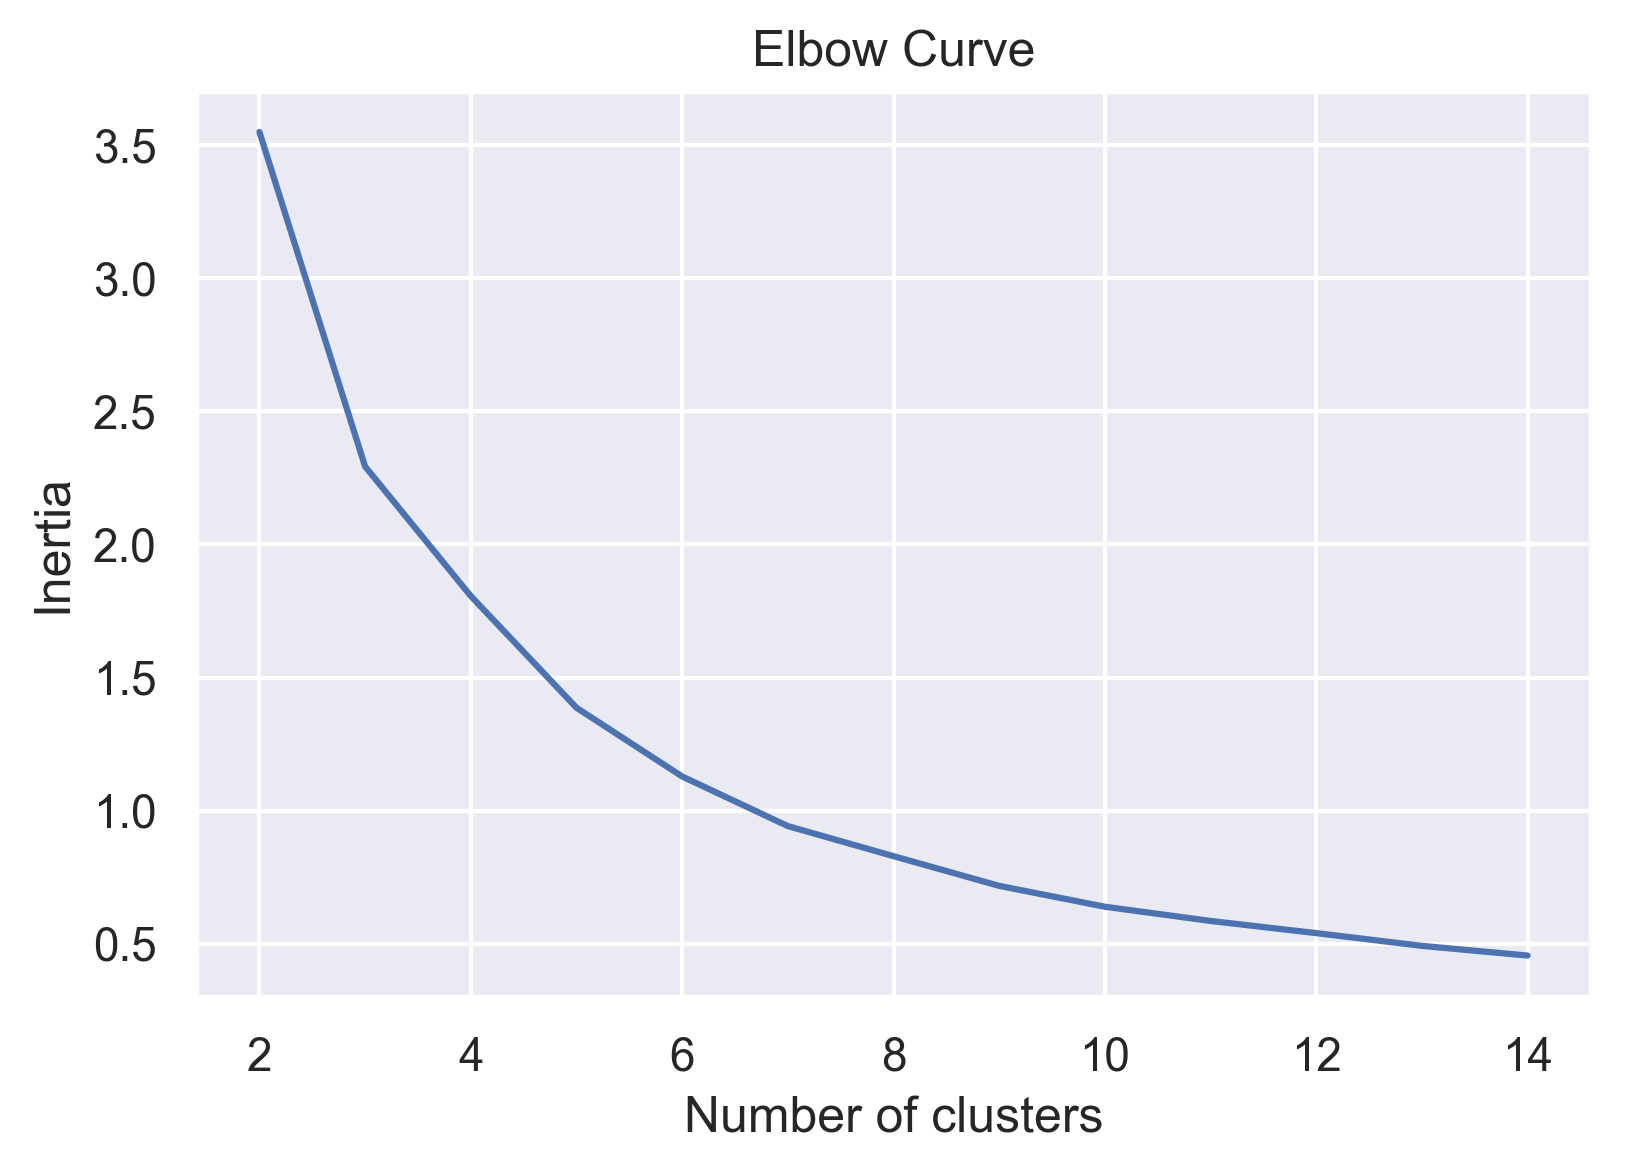

In [9]:
import pandas as pd
from sklearn.cluster import KMeans
from math import sqrt
import  pylab as pl
import numpy as np


data = df_union
returns = data.pct_change().mean() * N_STOCKS
variance = data.pct_change().std() * np.sqrt(N_STOCKS)
returns.columns = ["Returns"]
variance.columns = ["Variance"]
#Concatenating the returns and variances into a single data-frame
ret_var = pd.concat([returns, variance], axis = 1).dropna()
ret_var.columns = ["Returns","Variance"]
X =  ret_var.values #Converting ret_var into nummpy array
sse = []
for k in range(2,15):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)

    sse.append(kmeans.inertia_) #SSE for each n_clusters
pl.plot(range(2,15), sse)
pl.title("Elbow Curve")
pl.xlabel("Number of clusters")
pl.ylabel("Inertia")
pl.savefig("Elbow_Curve.png")
pl.show()

In [10]:
hyper_options = np.array([[0, 1],
                          [1, 0],
                          [0.5, 0.5],
                          [0.25, 0.75],
                          [0.75, 0.25],
                          [1/3, 2/3],
                          [2/3, 1/3]])



In [11]:
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
import  pylab as pl
import numpy as np
from sklearn import preprocessing

K = 4
colors = ['purple', 'blue', 'green', 'red'][:K]
results = []
results_score = []
# print(f"####### {sector} #########")
data = df_union
# PCT: Percentage change between the current and a prior element.
returns = data.pct_change().mean() * 252
variance = data.pct_change().std() * np.sqrt(252)
returns.columns = ["Returns"]
variance.columns = ["Variance"]
#Concatenating the returns and variances into a single data-frame
ret_var = pd.concat([returns, variance], axis = 1).dropna()
ret_var.columns = ["Returns","Variance"]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, n

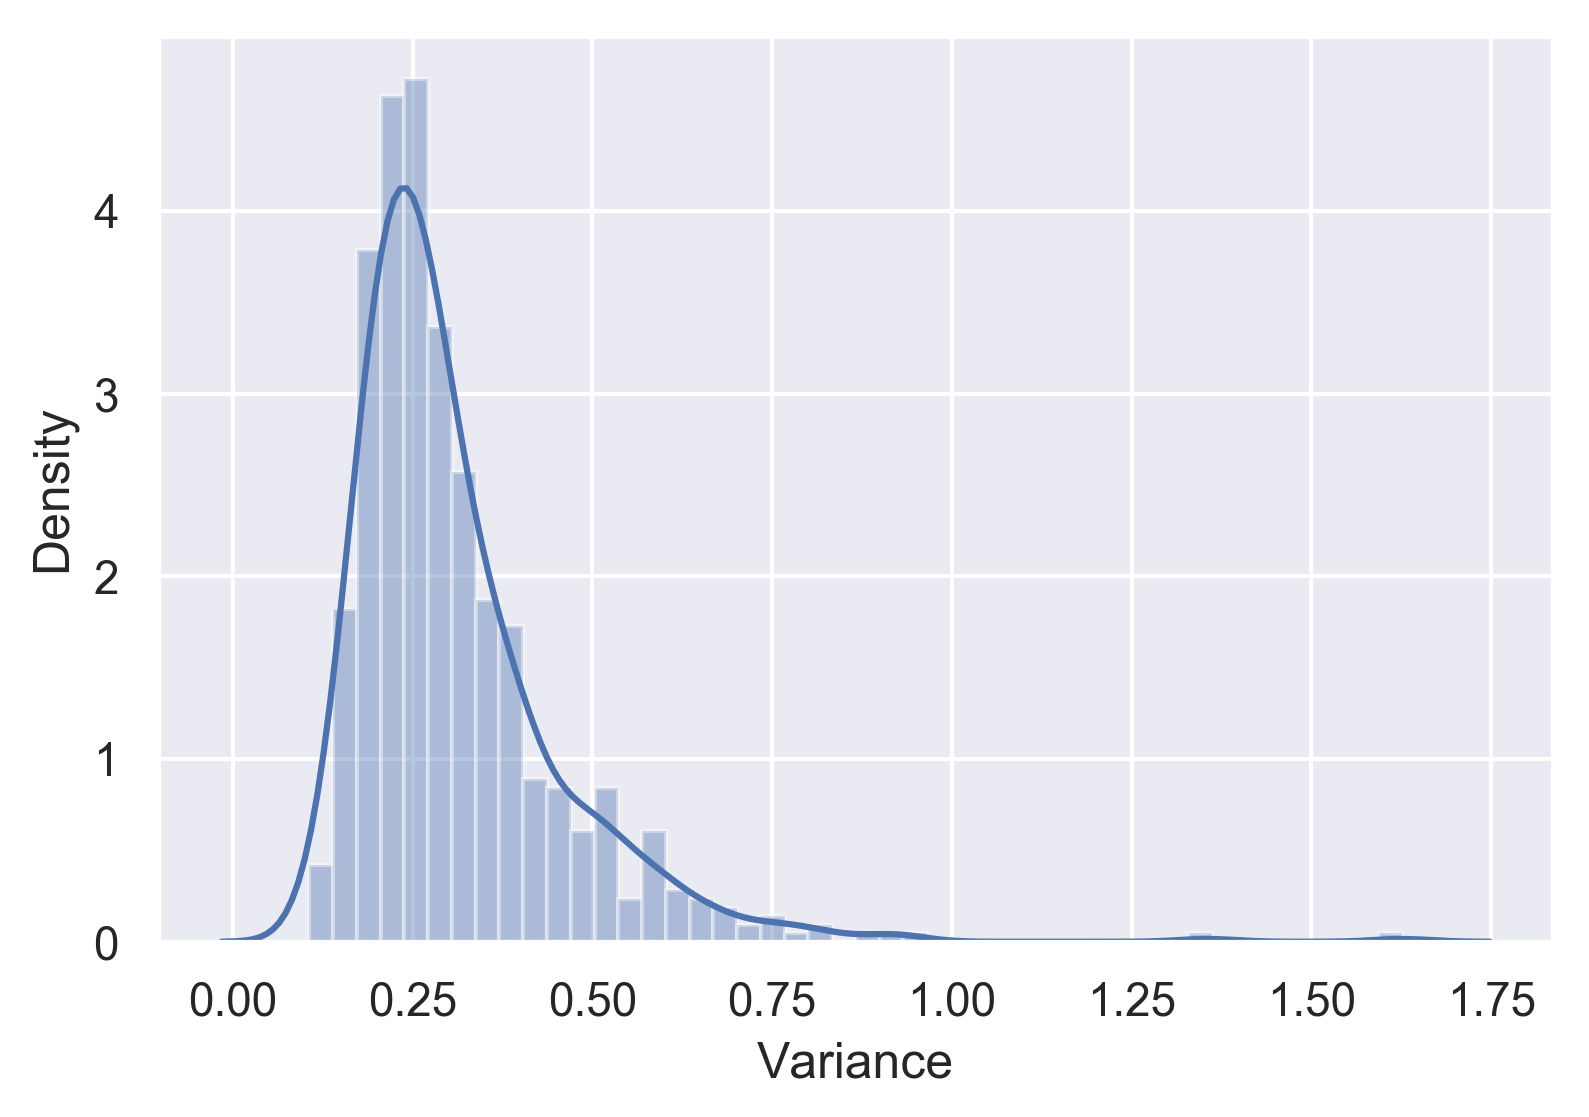

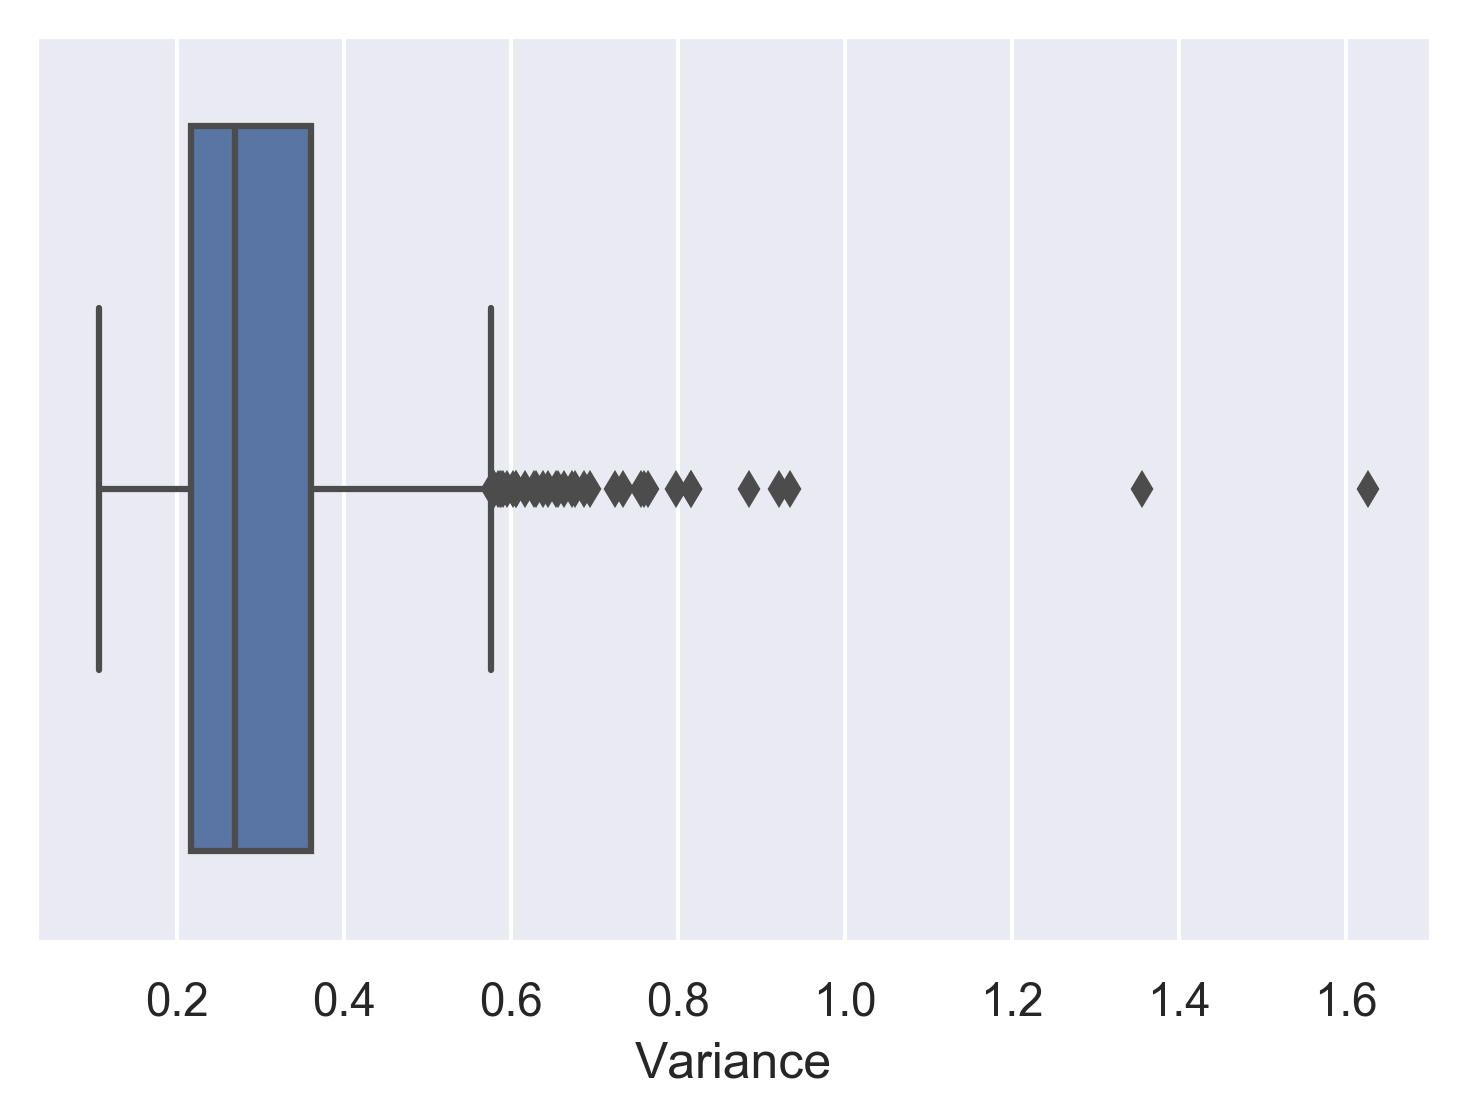

In [12]:
from matplotlib.cbook import boxplot_stats
# todo - try to extracy the boundaries of the boxPlot
sns.distplot(ret_var["Variance"])
plt.show()
sns.boxplot(ret_var["Variance"])
plt.show()

upper_limit = ret_var['Variance'].quantile(0.99)
lower_limit = ret_var['Variance'].quantile(0.01)

left_bound = boxplot_stats(ret_var['Variance']).pop(0)['whislo']
right_bound = boxplot_stats(ret_var['Variance']).pop(0)['whishi']

ret_var = ret_var[(ret_var['Variance'] <= right_bound) & (ret_var['Variance'] >= left_bound)]


In [13]:
data = data[data.columns.intersection(ret_var.index.tolist())]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


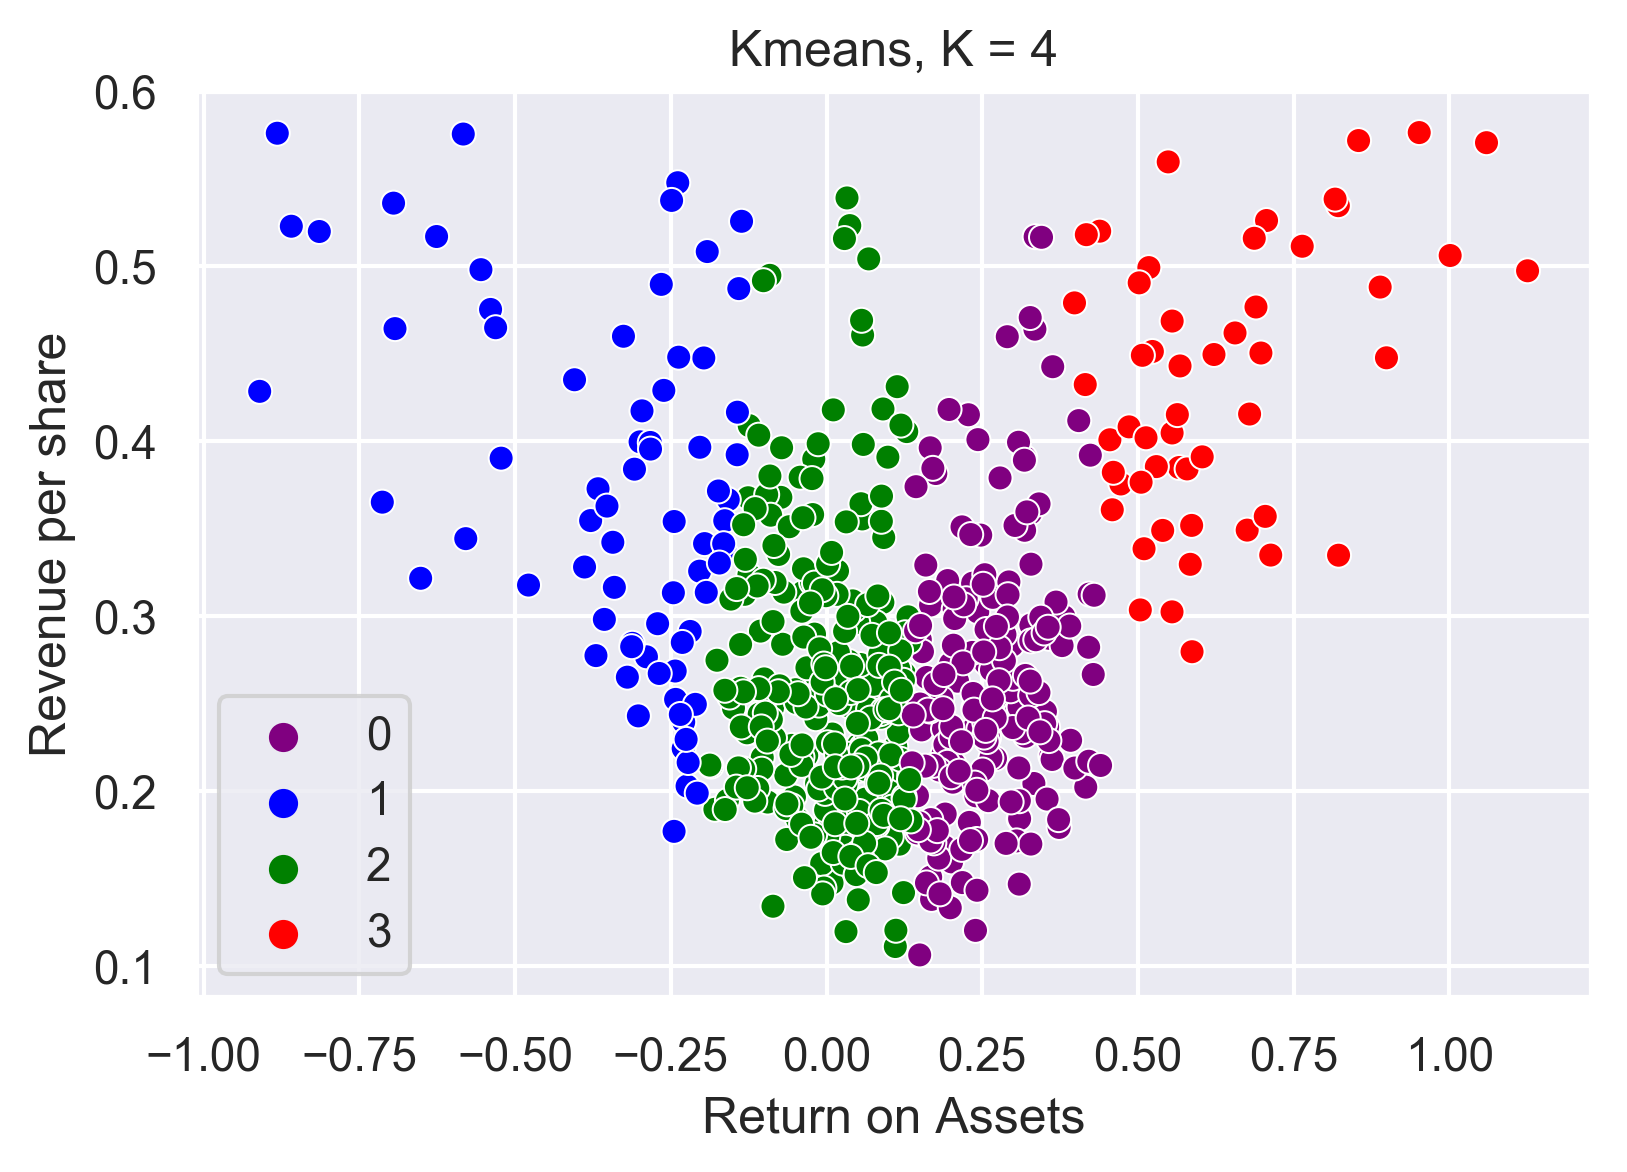

In [14]:
X =  ret_var.values #Converting ret_var into nummpy array

kmeans = KMeans(n_clusters=K).fit(X)
centroids = kmeans.cluster_centers_
# kmeans = X.to_numpy()

sns.scatterplot(X[:, 0], X[:, 1], hue=kmeans.labels_, palette=colors)
plt.title(f"Kmeans, K = {K}")
plt.xlabel("Return on Assets")
plt.ylabel("Revenue per share")
plt.savefig("results/scatter.png")
pl.show()

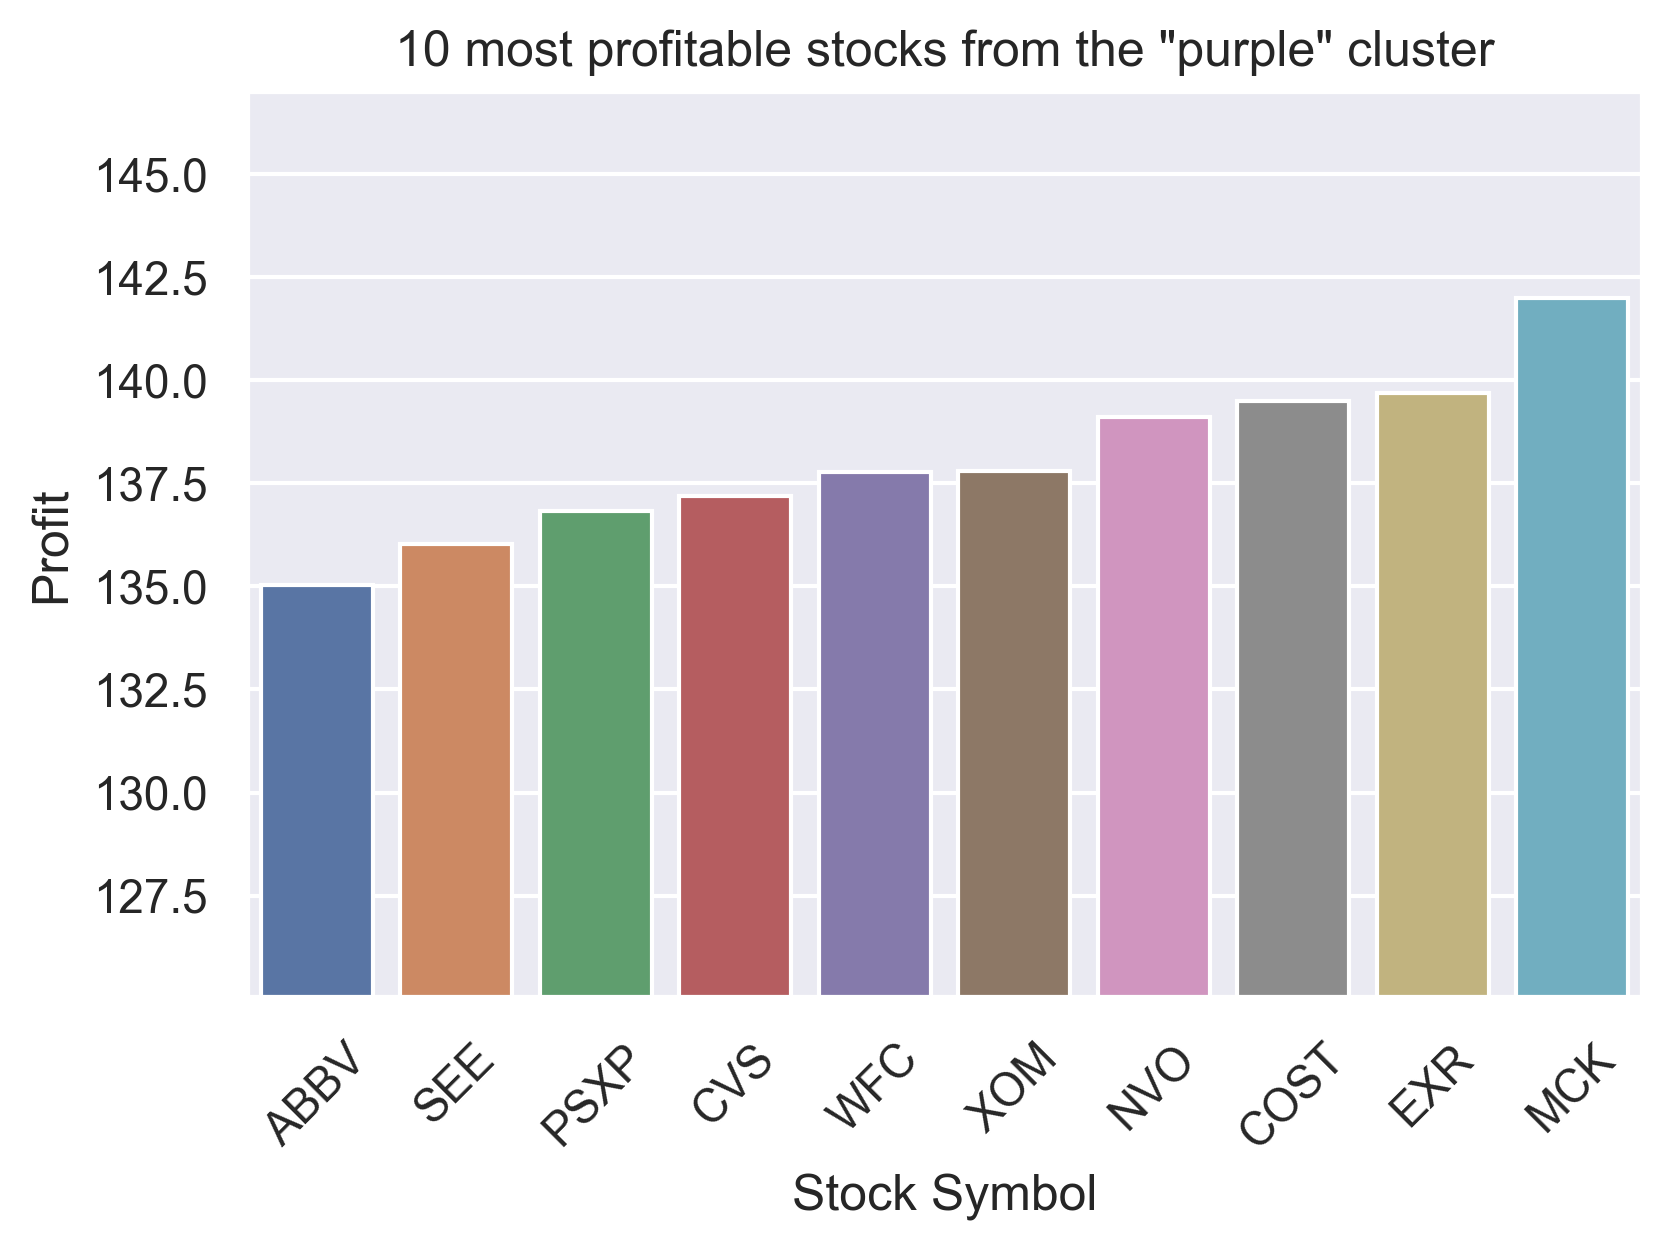

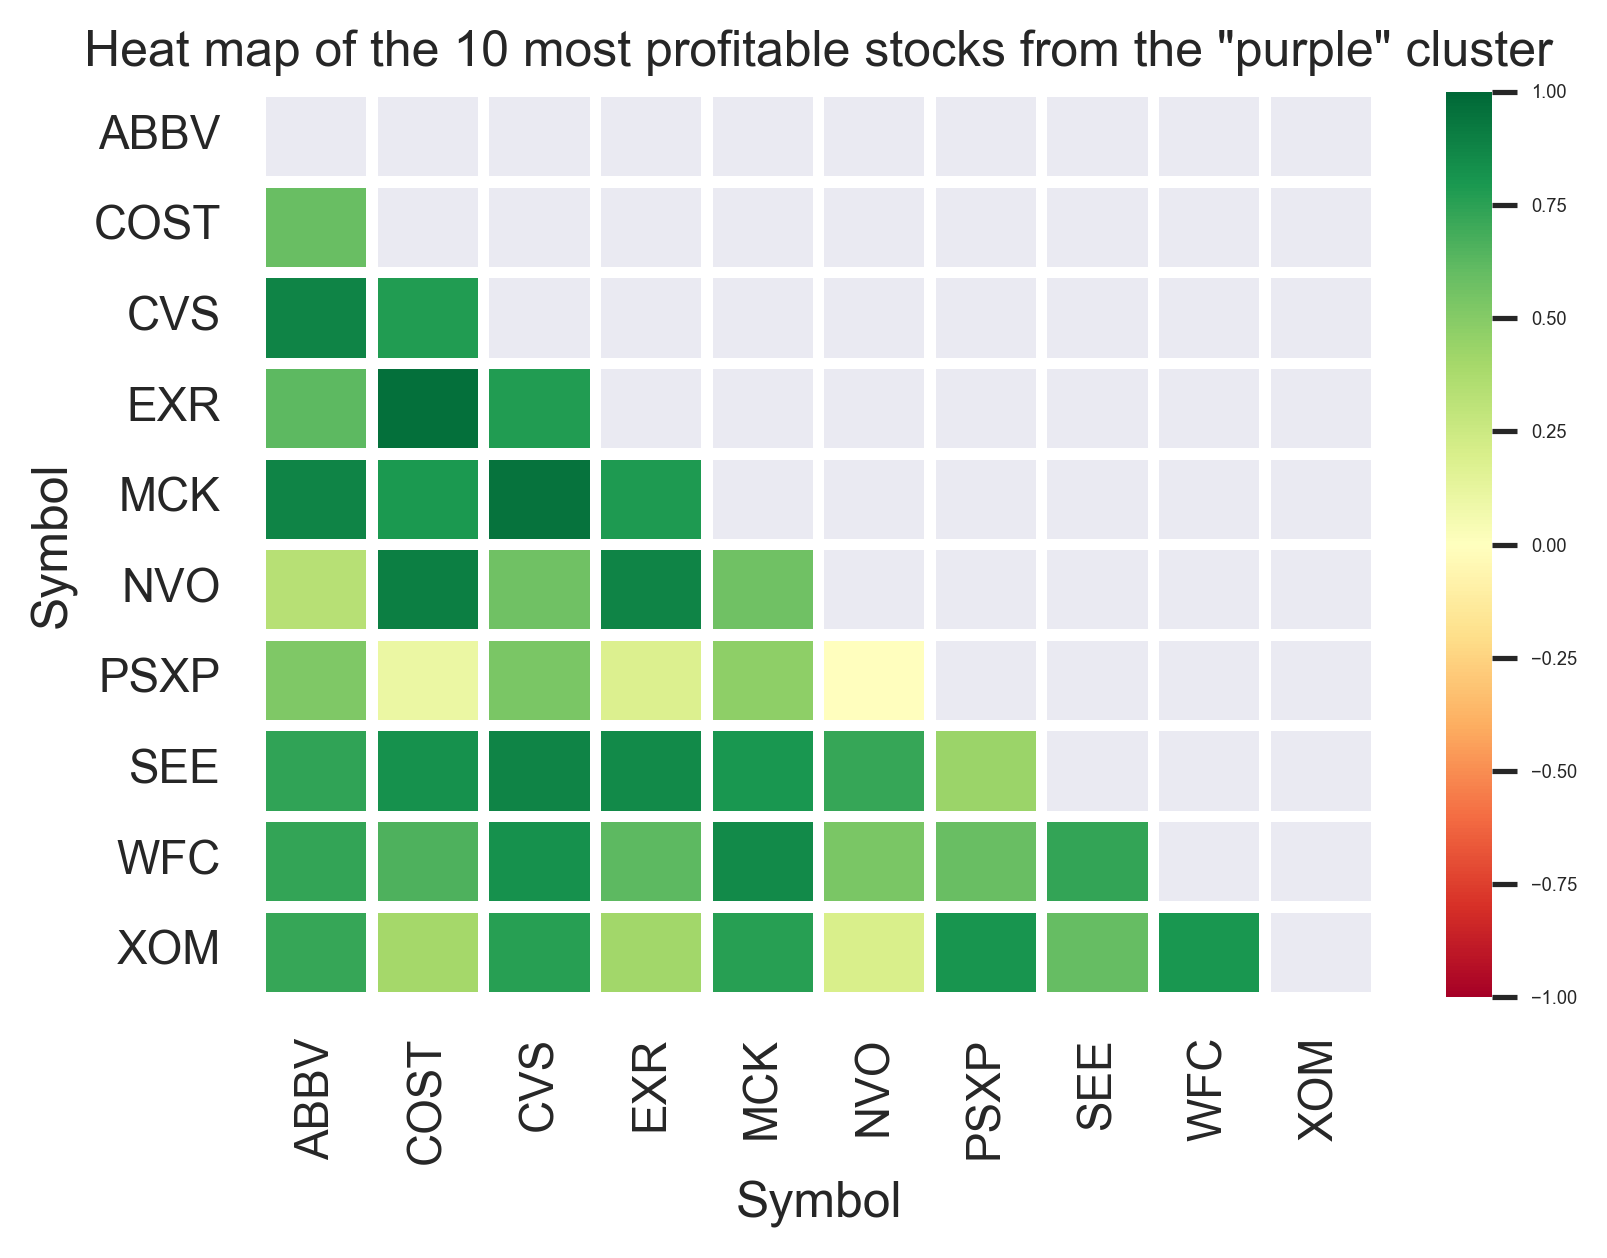

['WLK', 'MCK', 'SNPS', 'WLK', 'IBN', 'ULTA', 'UPS']
['GNRC', 'BA', 'GNRC', 'GNRC', 'GNRC', 'GNRC', 'GNRC']
['AYI', 'TRP', 'AYI', 'AYI', 'FCFS', 'AYI', 'FCFS']
['GFI', 'DVN', 'WES', 'GFI', 'LNG', 'GFI', 'MPC']


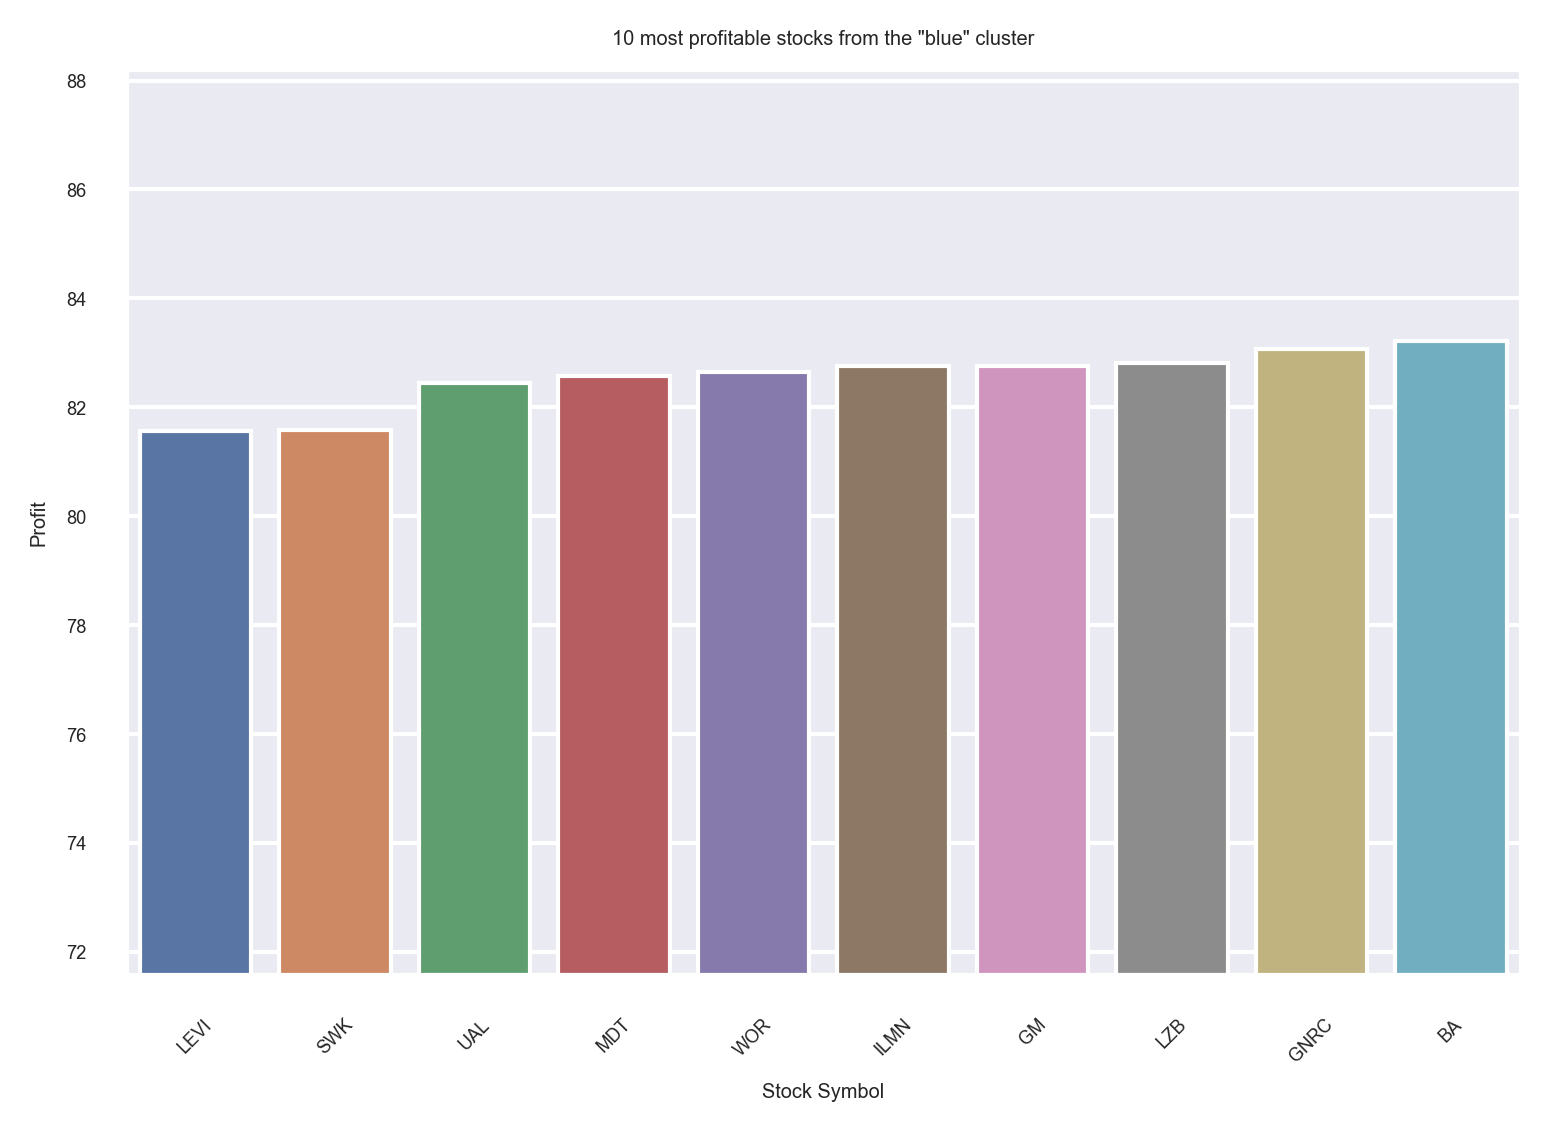

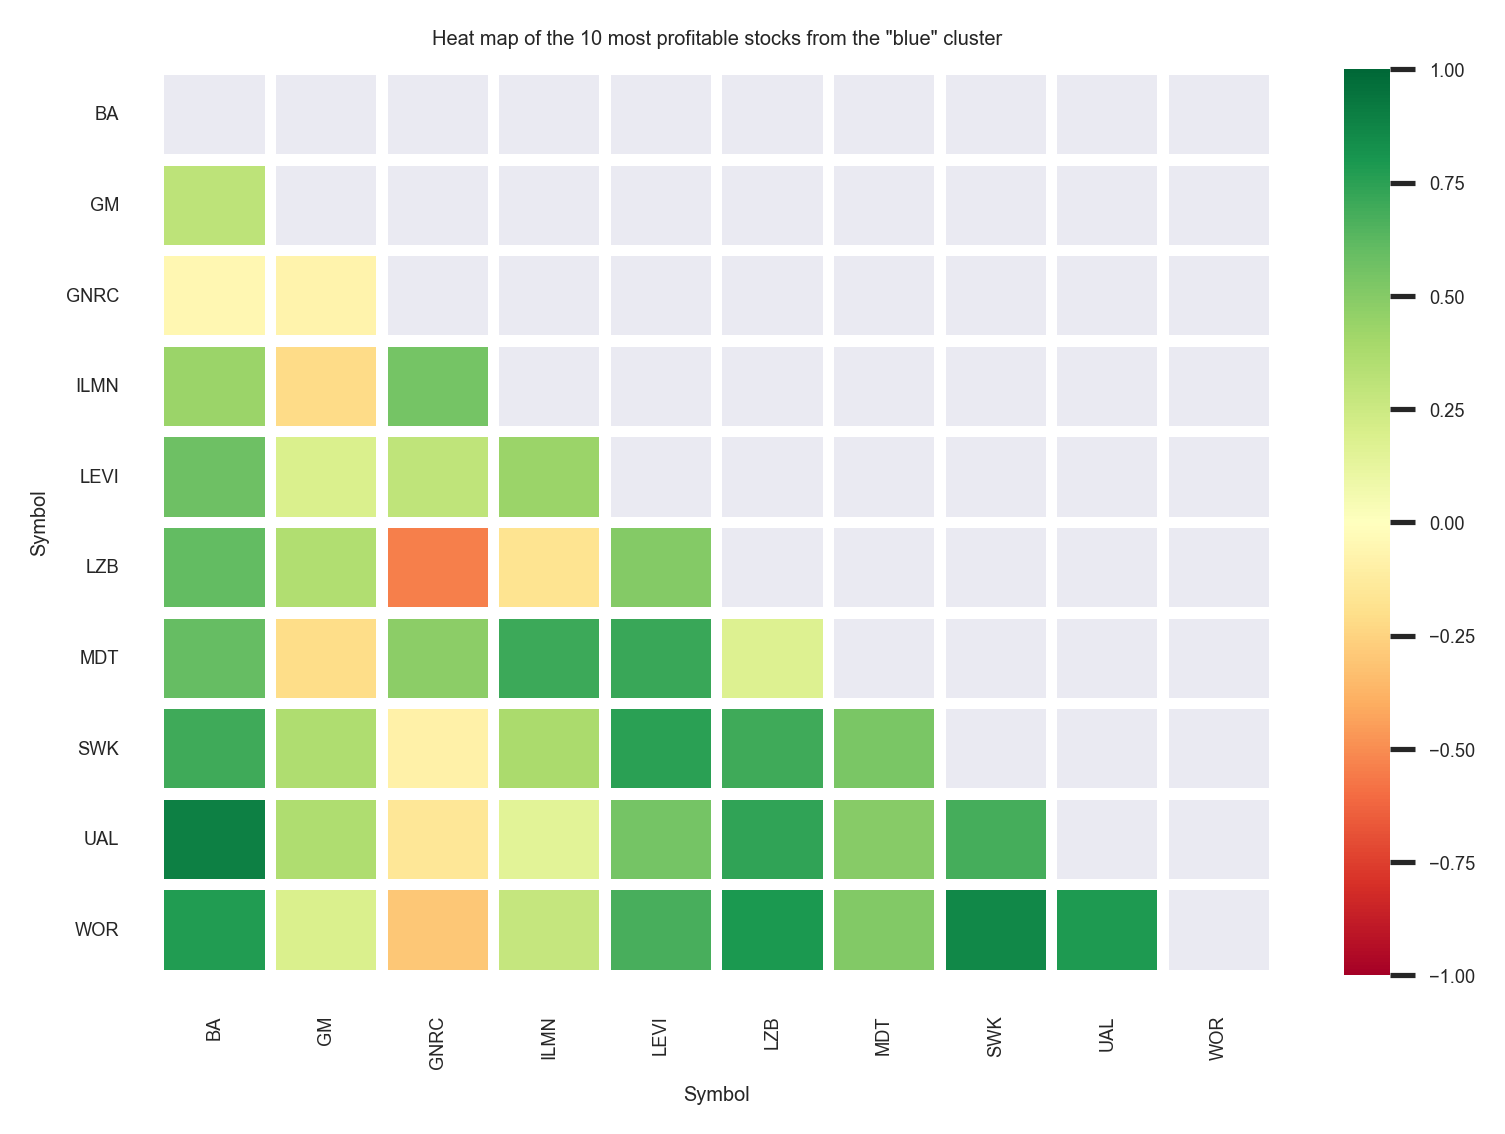

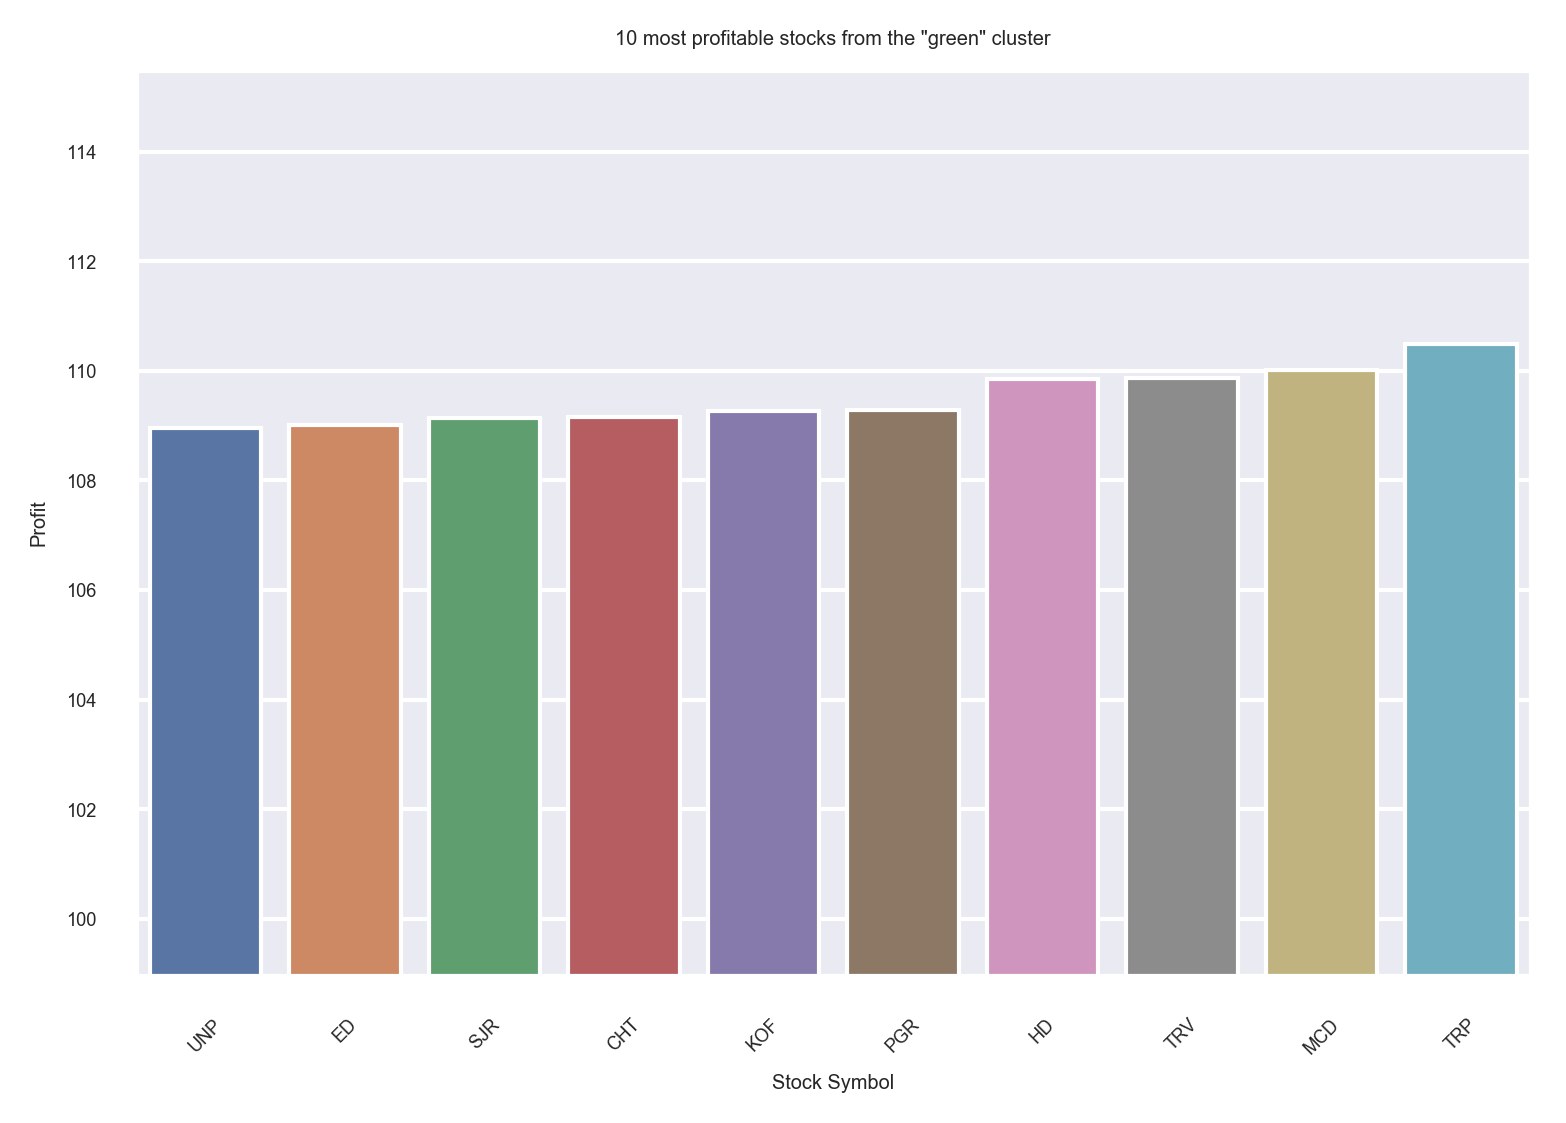

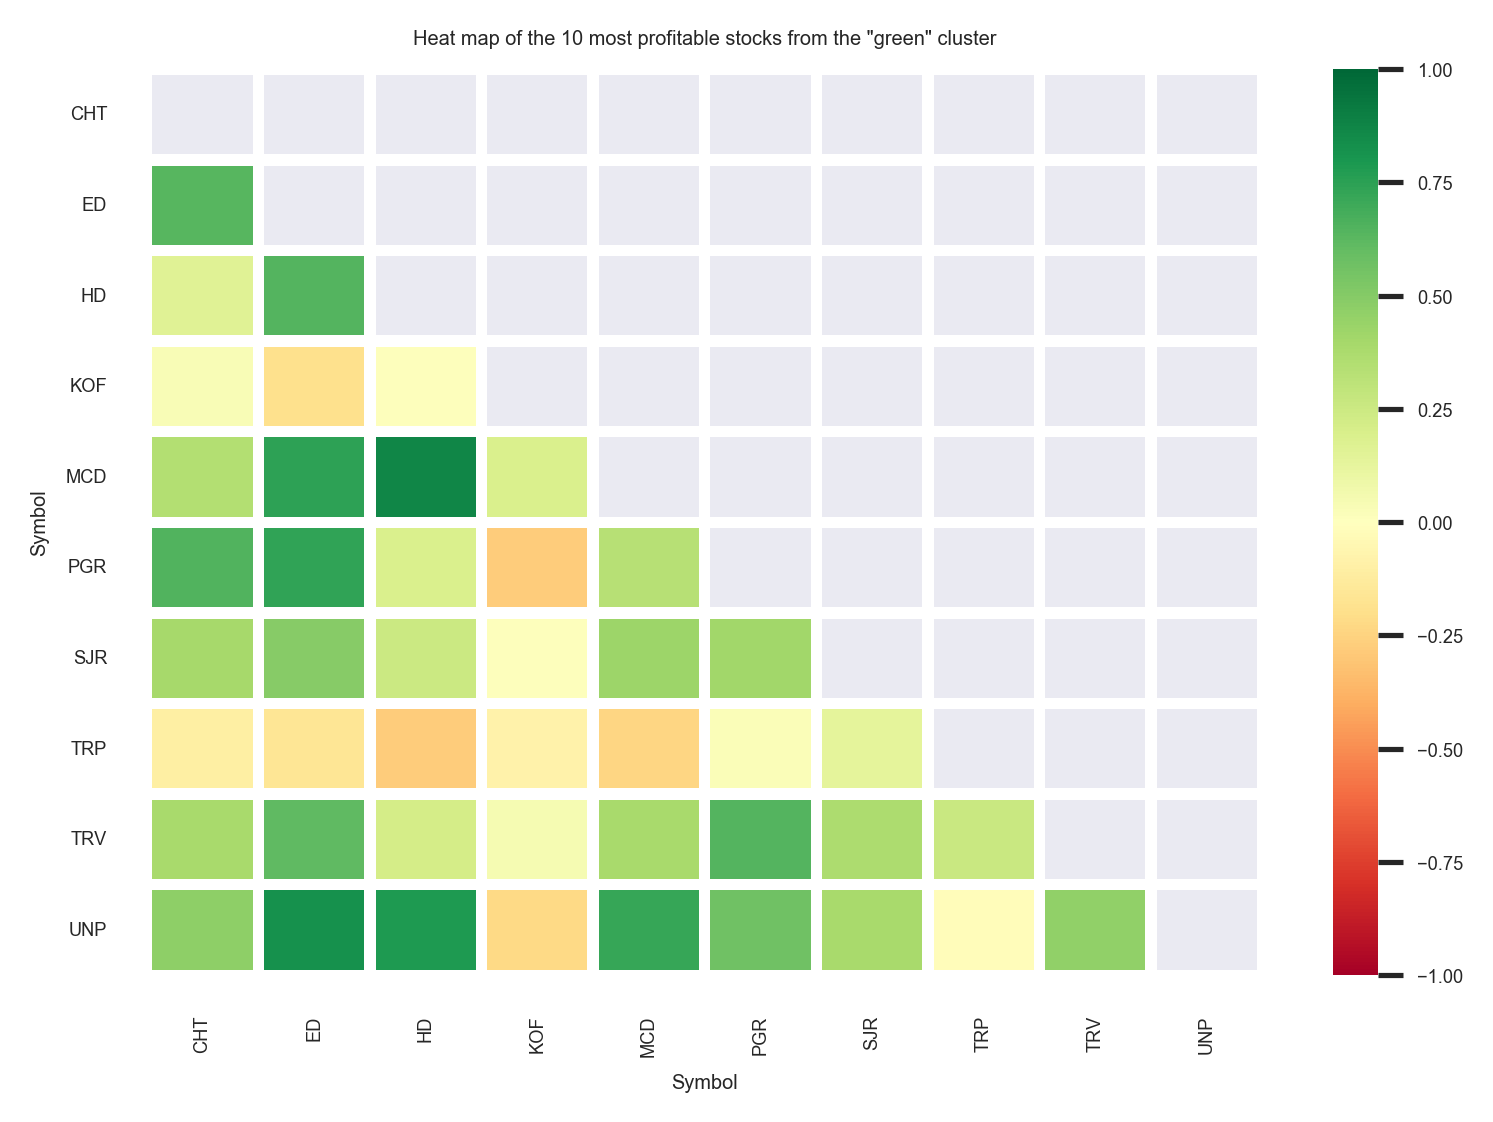

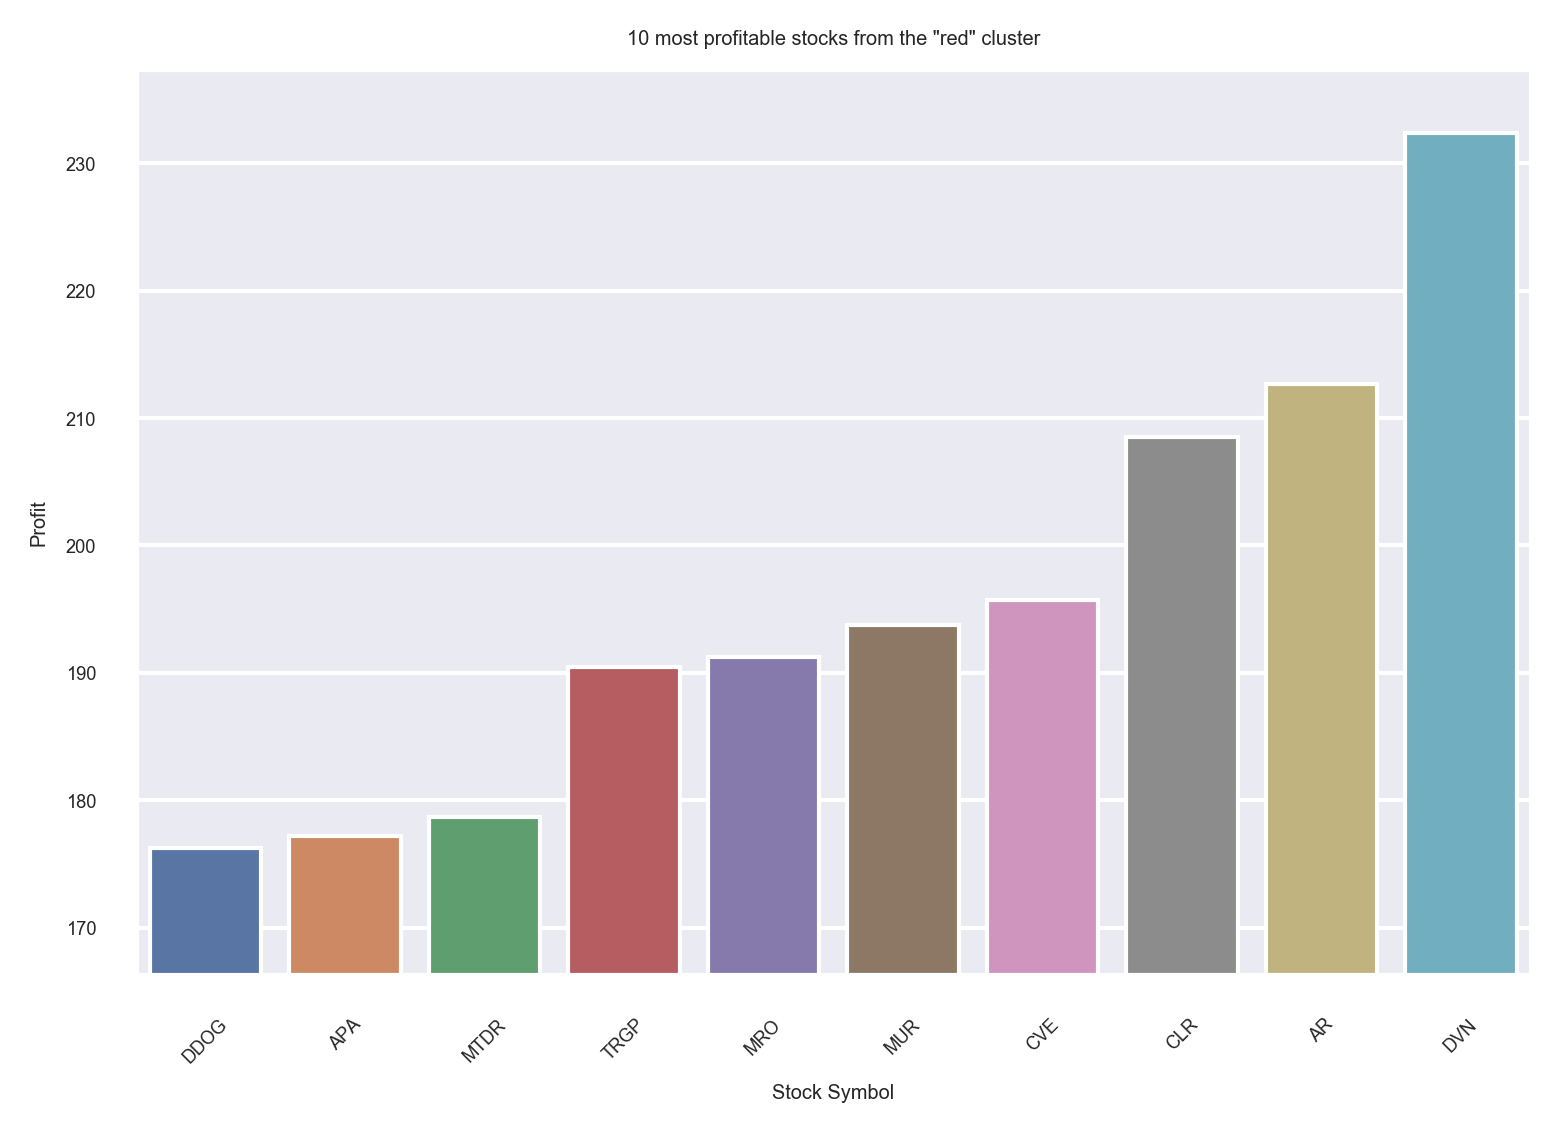

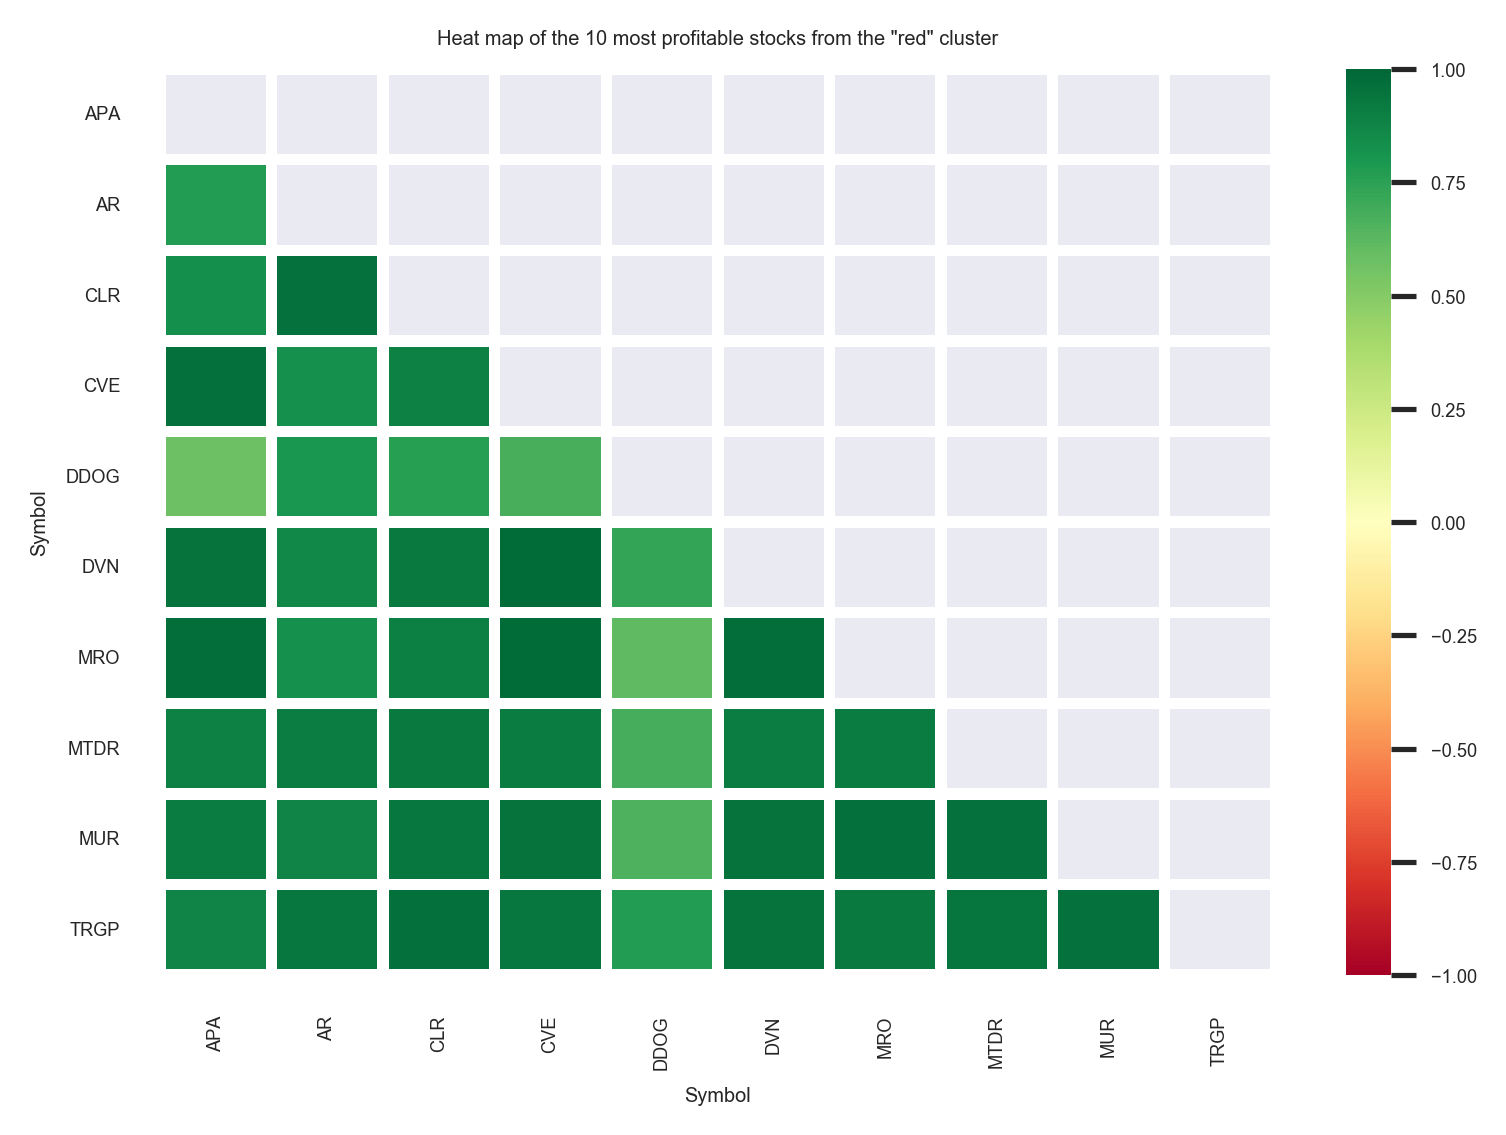

In [15]:
x_dist = kmeans.transform(X) ** 2
x_dist = x_dist.sum(axis=1)

new_data = (data.iloc[-1] * 100) / data.iloc[0]
tickers = data.columns
values = new_data.values

tickers_for_corr = []
for i in range(K):
    indexes = kmeans.labels_ == i
    t = tickers[indexes]
    v = values[indexes]
    centroid_dists = - x_dist[indexes] / np.sum(x_dist[indexes])
    df = pd.DataFrame({'Profit': v, "Stock Symbol": t, "centroid dist": centroid_dists}).sort_values(by='Profit')
    y_bottom = max(0, min(df["Profit"][-10:])-10)
    y_upper = max(df["Profit"][-10:]) + 5

    tickers_for_corr += df[-10: ]["Stock Symbol"].tolist()

    sns.barplot(x='Stock Symbol', y='Profit', data=df[-10:])
    plt.xticks(rotation=45)
    plt.ylim(y_bottom, y_upper)
    plt.title(f"10 most profitable stocks from the \"{colors[i]}\" cluster")
    plt.xlabel("Stock Symbol")
    plt.ylabel("Profit")
    plt.savefig(f"results/{colors[i]}.png")
    plt.show()

    plt.title(f"Heat map of the 10 most profitable stocks from the \"{colors[i]}\" cluster")
    generate_heat_map(df_union[df_union.columns.intersection(df[-10: ]["Stock Symbol"].tolist())])

    df["Profit"] /= np.sum(v)
    max_results = []
    max_results_score = []
    for j in range(len(hyper_options)):
        tmp = ((df["Profit"] * hyper_options[j][0]) + (df["centroid dist"] * hyper_options[j][1])).tolist()
        df[f'{j}'] = tmp
        max_results.append(df.loc[df[f'{j}'].idxmax()]["Stock Symbol"])
        max_results_score.append(df.loc[df[f'{j}'].idxmax()][f'{j}'])
    print(max_results)
    results.append(max_results[-1])
    results_score.append(max_results_score[-1])


In [27]:
results

['VRTX', 'UPS', 'MTCH', 'MPC', 'VRTX', 'UPS', 'MTCH', 'MPC']

In [ ]:
generate_heat_map(df_union[df_union.columns.intersection(results)])

In [30]:
print("We recommend to invest in:")
for i in range(K):
    stock_symbol = results[i]
    print(stock_symbol)
    stock_sector = stocks_screener.loc[stocks_screener["Symbol"] == stock_symbol]["Sector"].values[0]
    print(f'\'{stock_symbol}\' stock from the {stock_sector} sector, with score of {np.round(results_score[i], 3)}, from the \"{colors[i]}\" cluster')

We recommend to invest in:
'VRTX' stock from the 1 sector, with score of 0.002, from the "purple" cluster
'UPS' stock from the 1 sector, with score of 0.002, from the "blue" cluster
'MTCH' stock from the 1 sector, with score of 0.013, from the "green" cluster
'MPC' stock from the 1 sector, with score of 0.007, from the "red" cluster


In [94]:
import math
mySeries = df_union.to_numpy().T
# cluster_count = math.ceil(math.sqrt(len(mySeries)))
cluster_count = 8
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(mySeries)



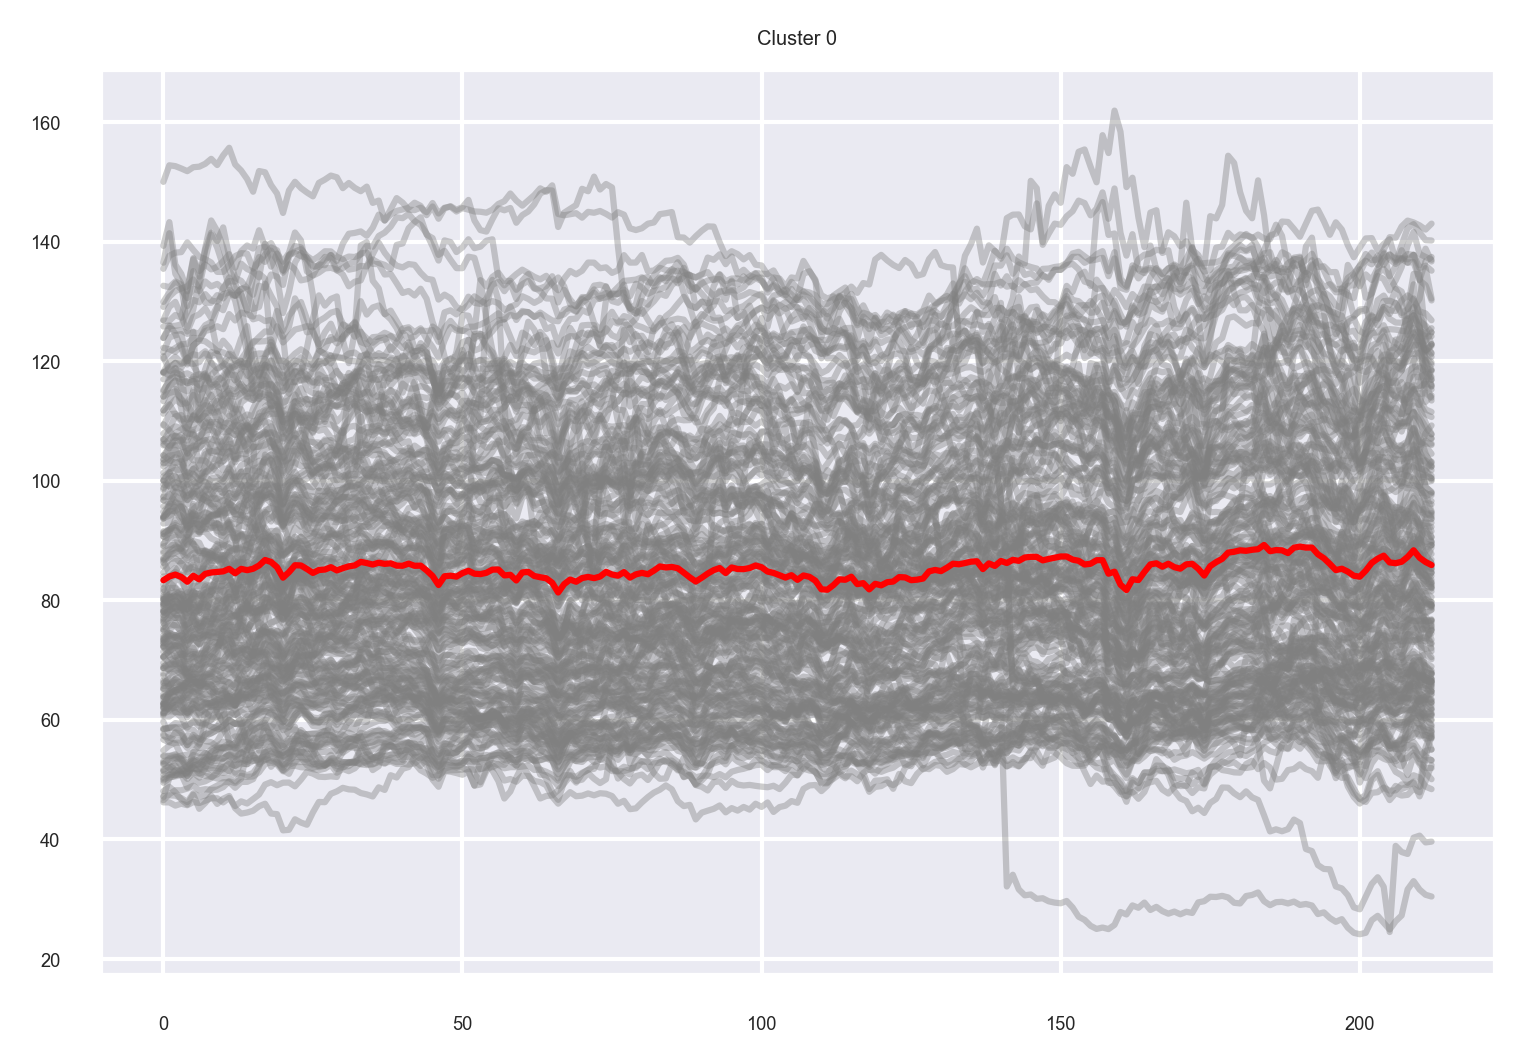

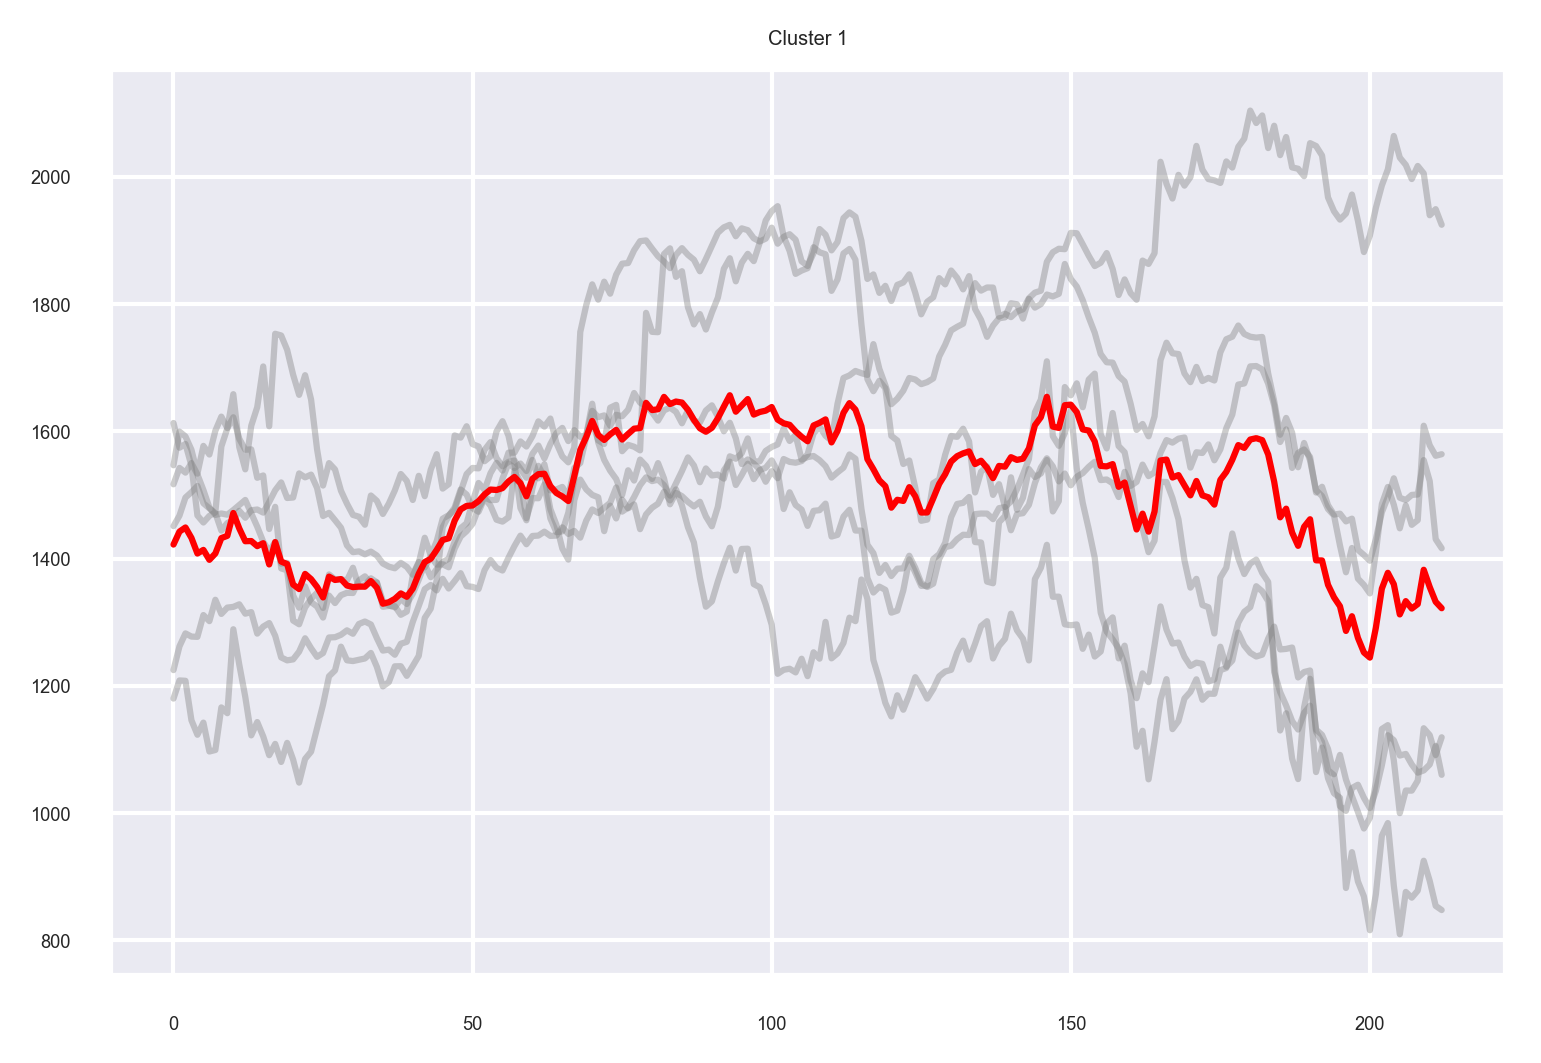

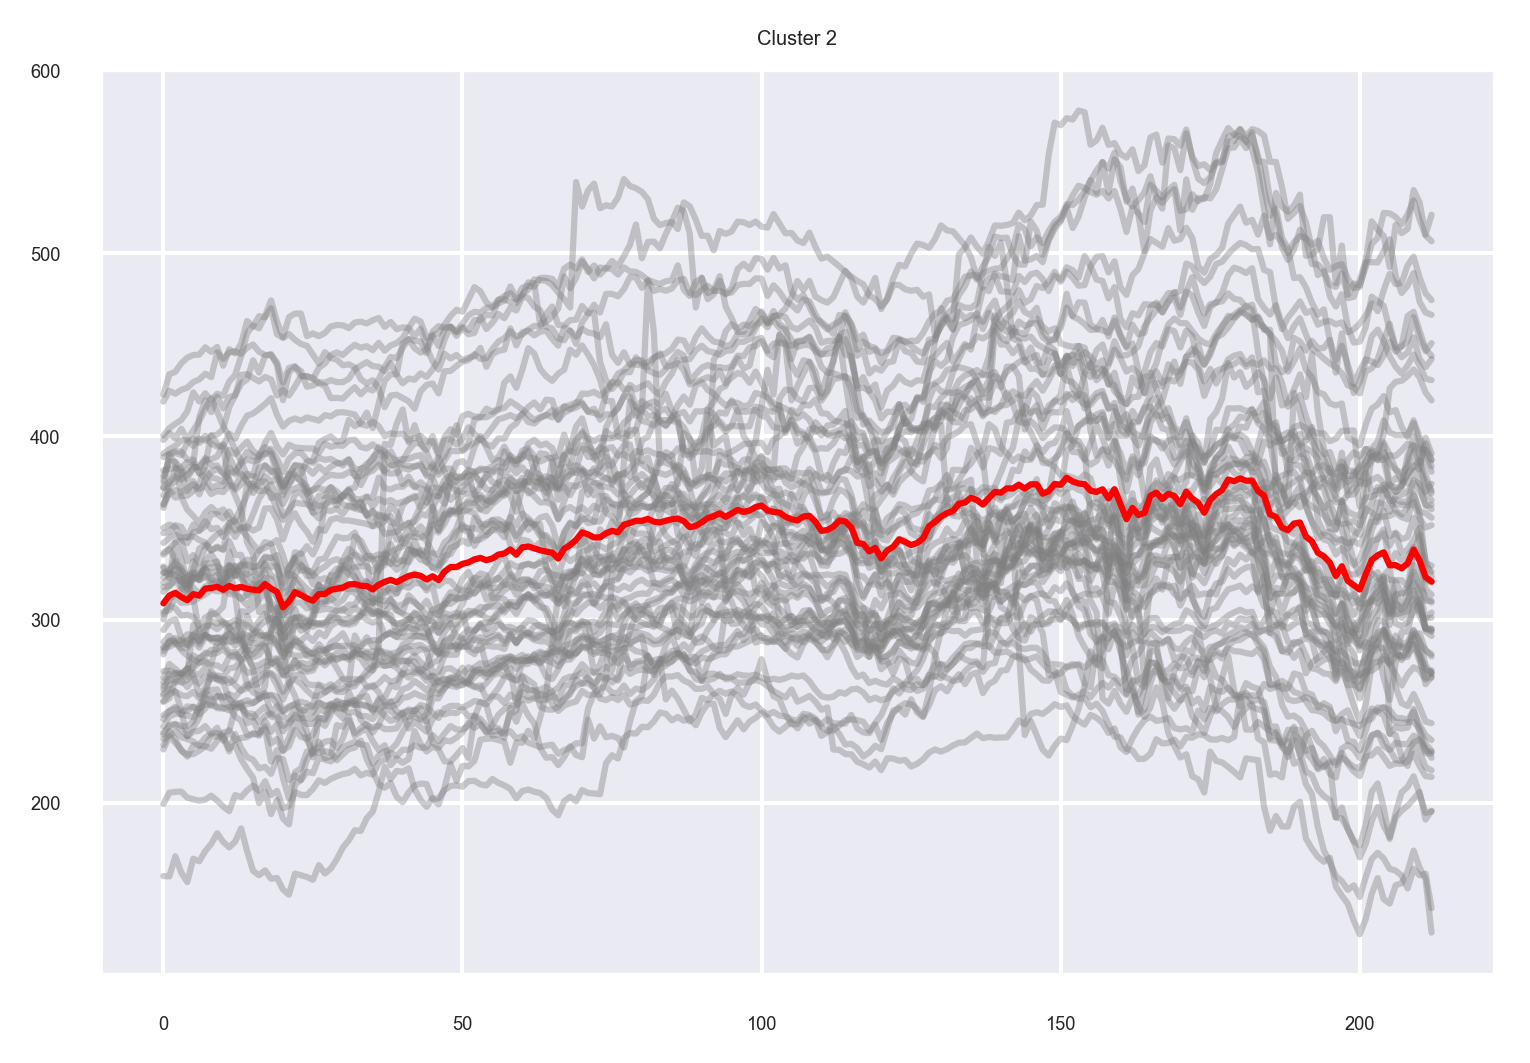

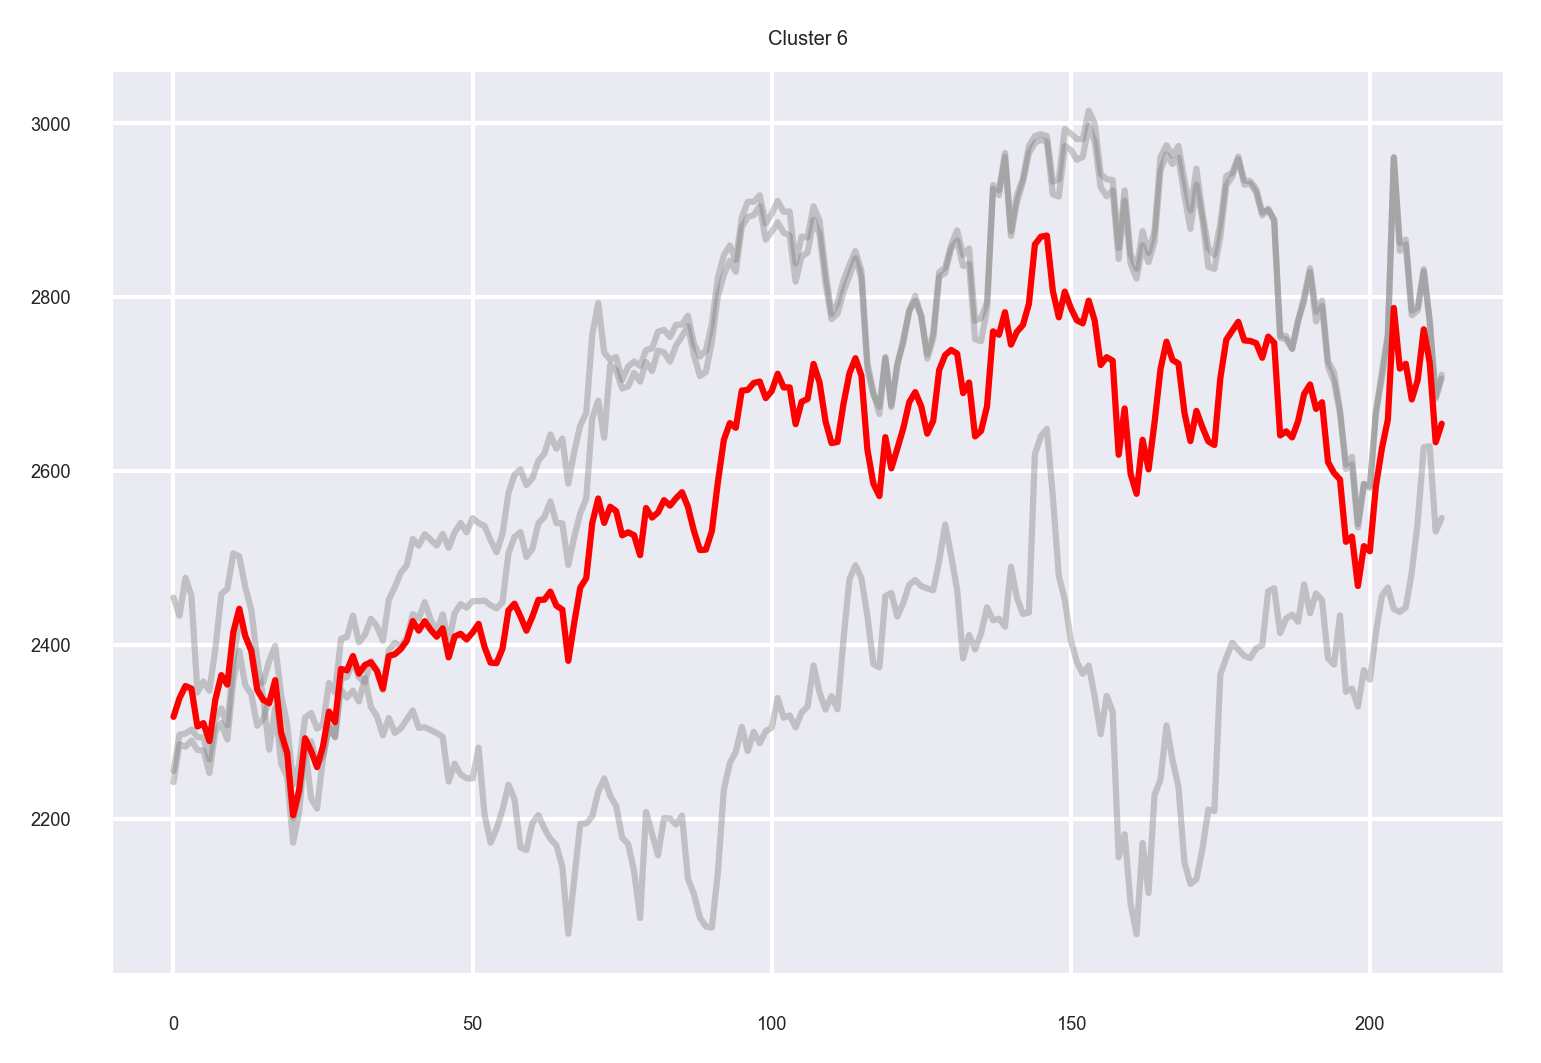

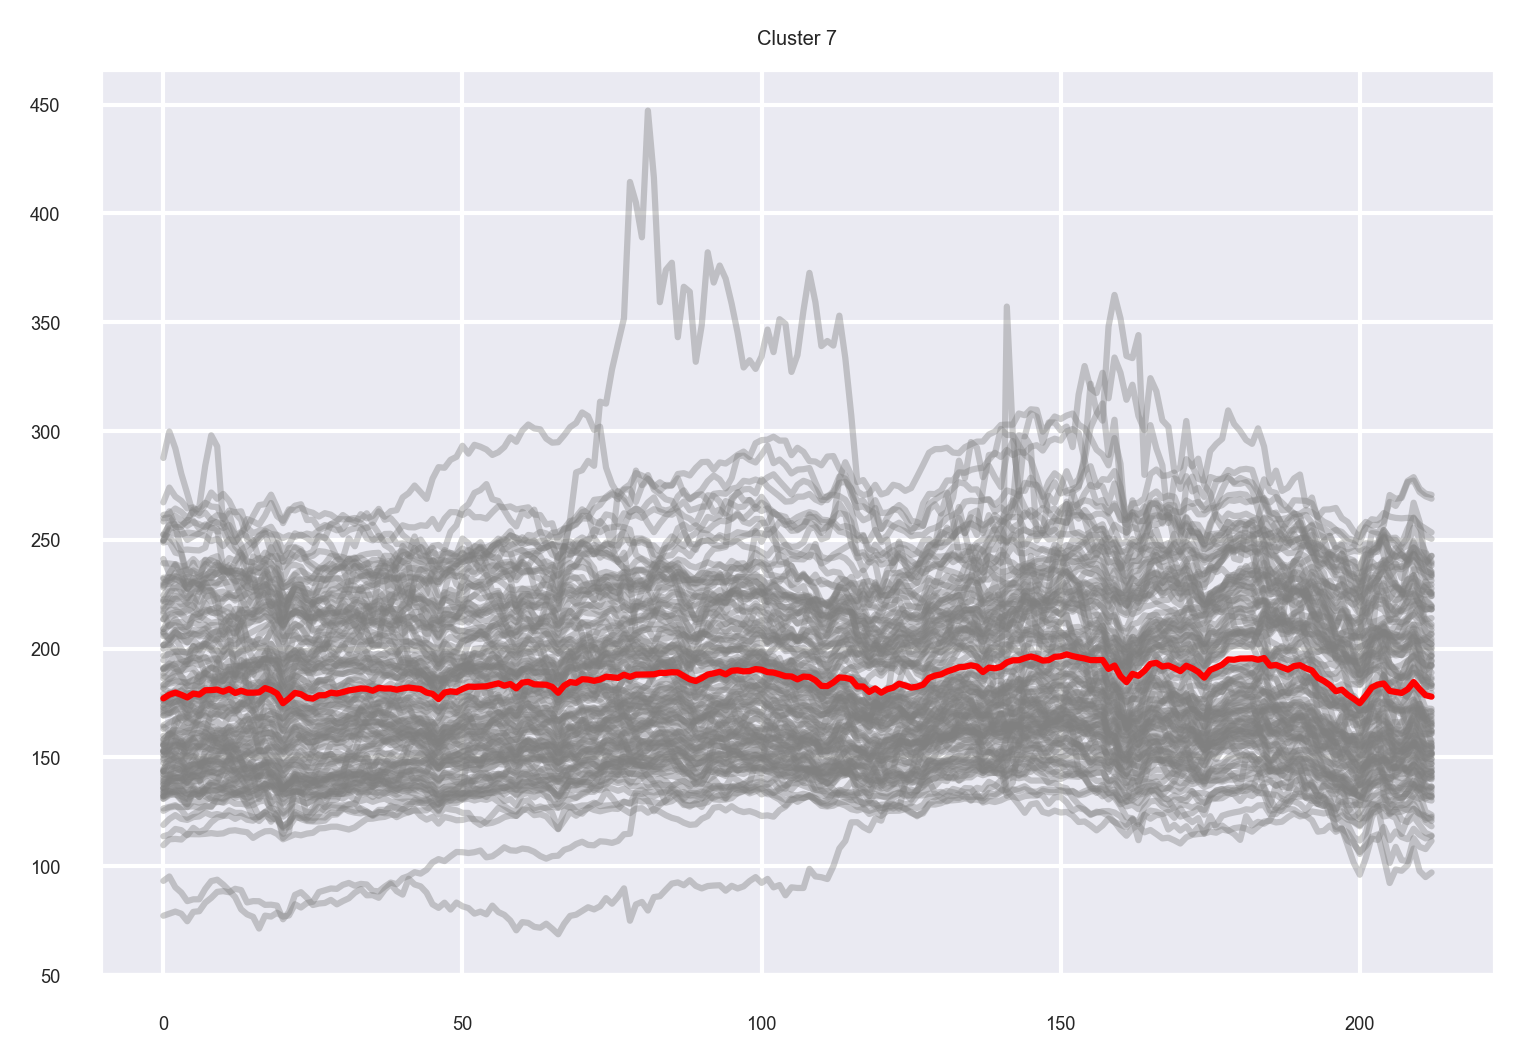

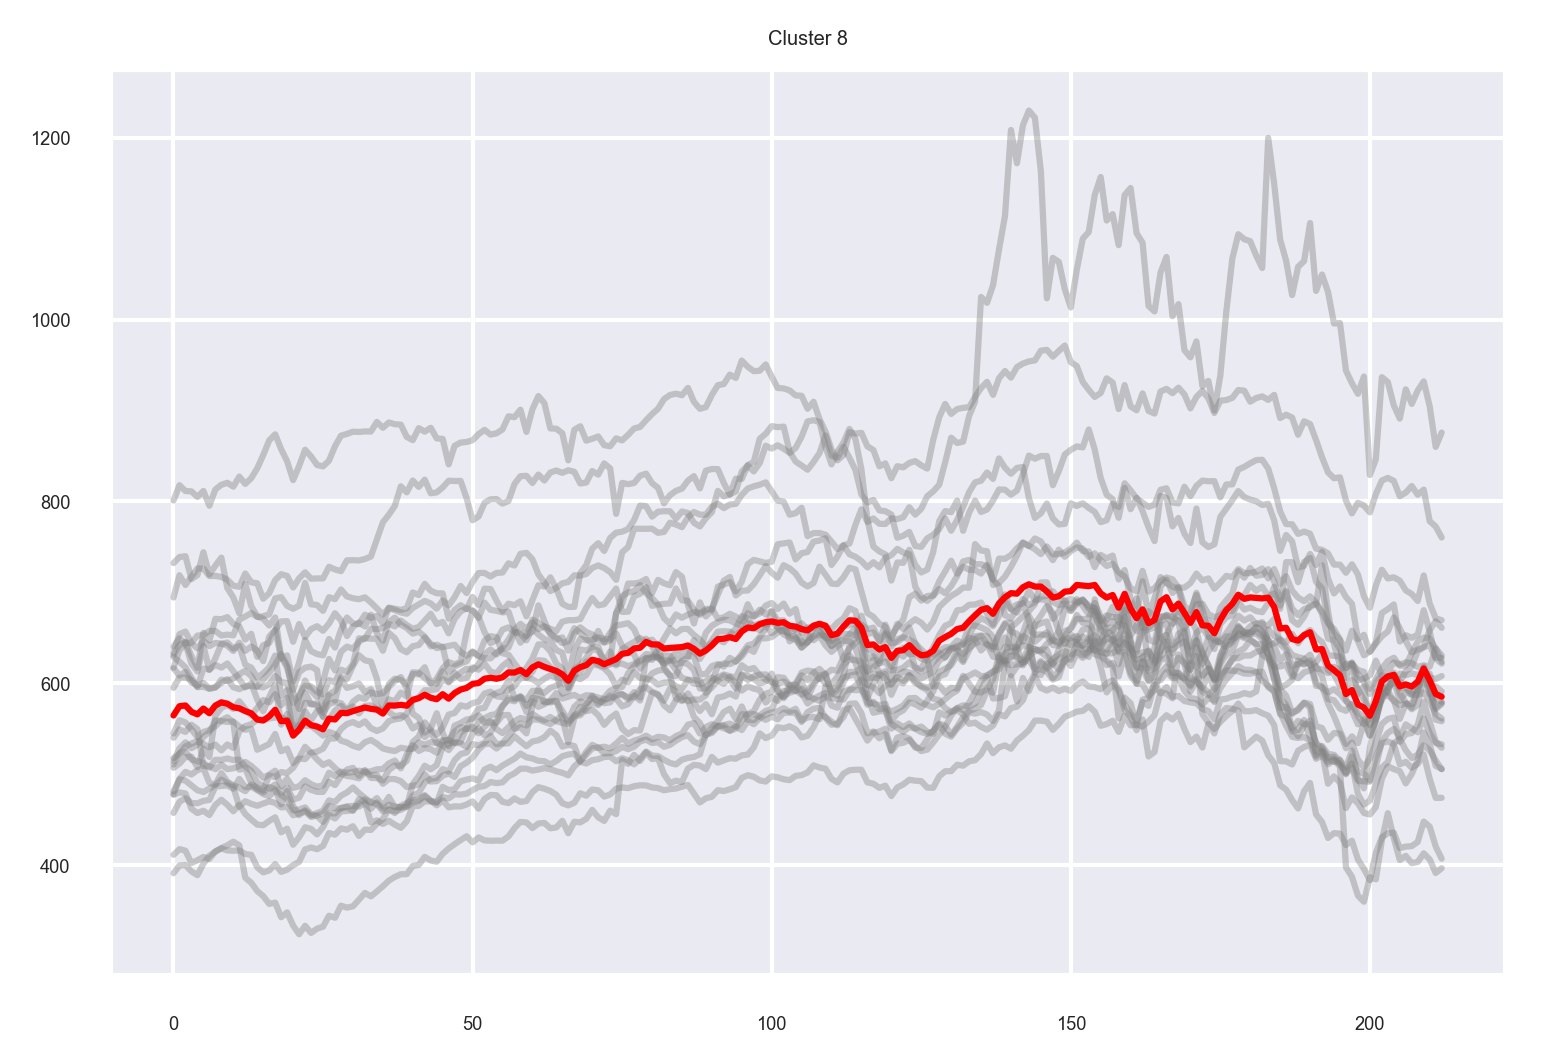

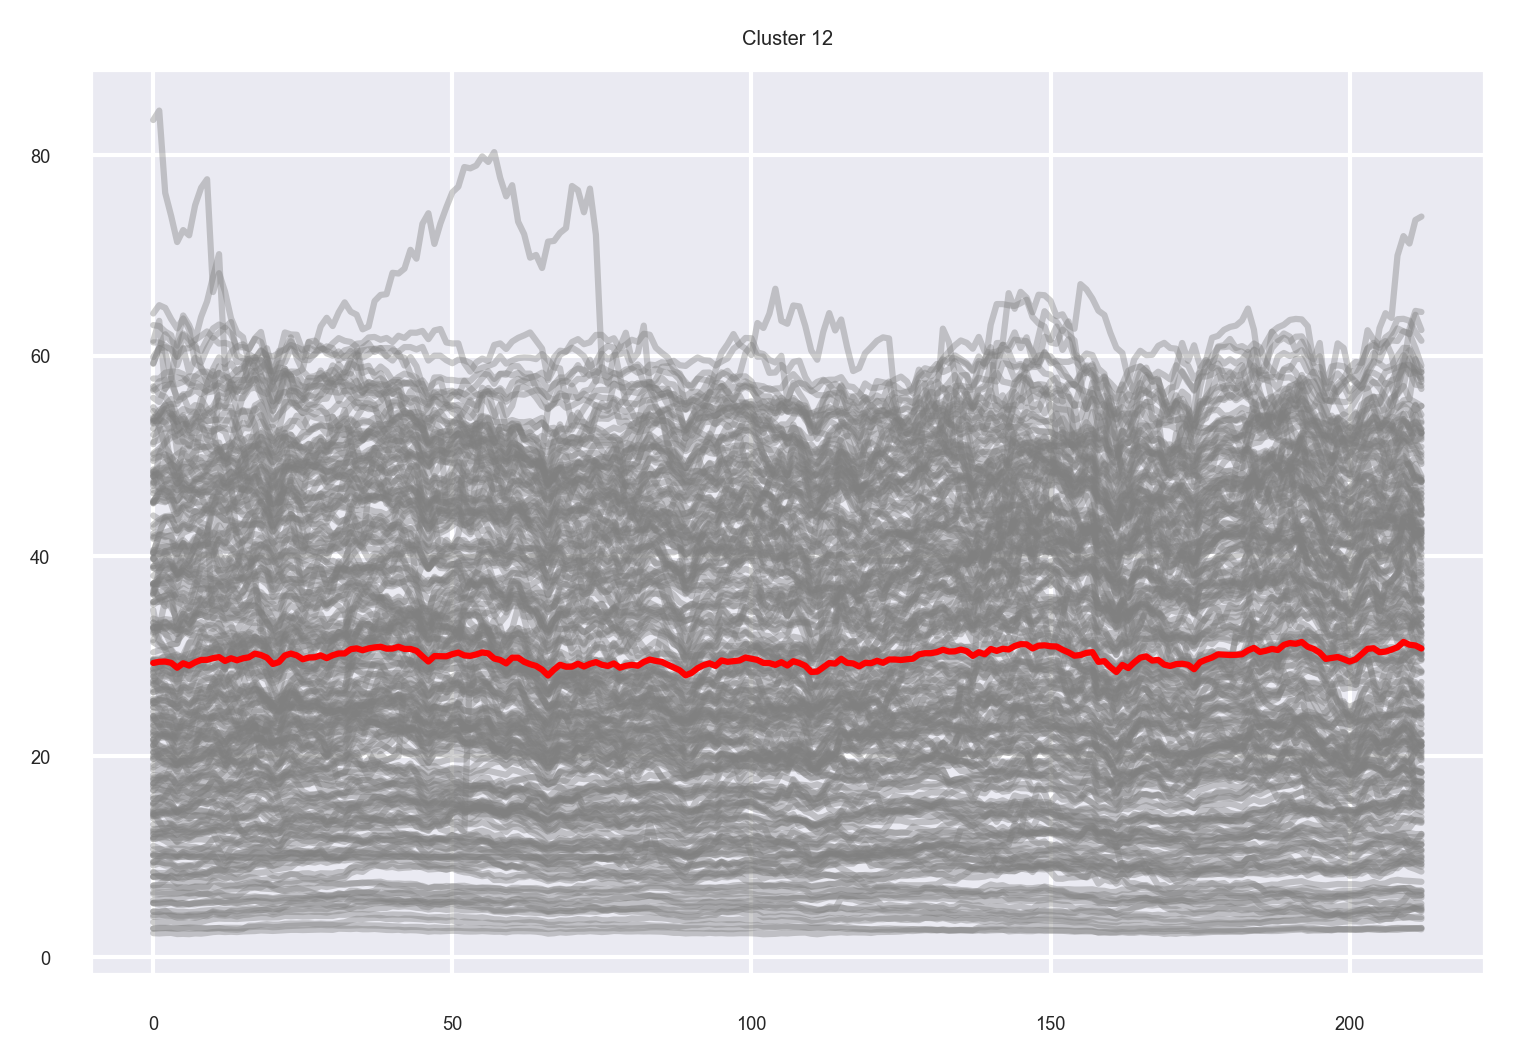

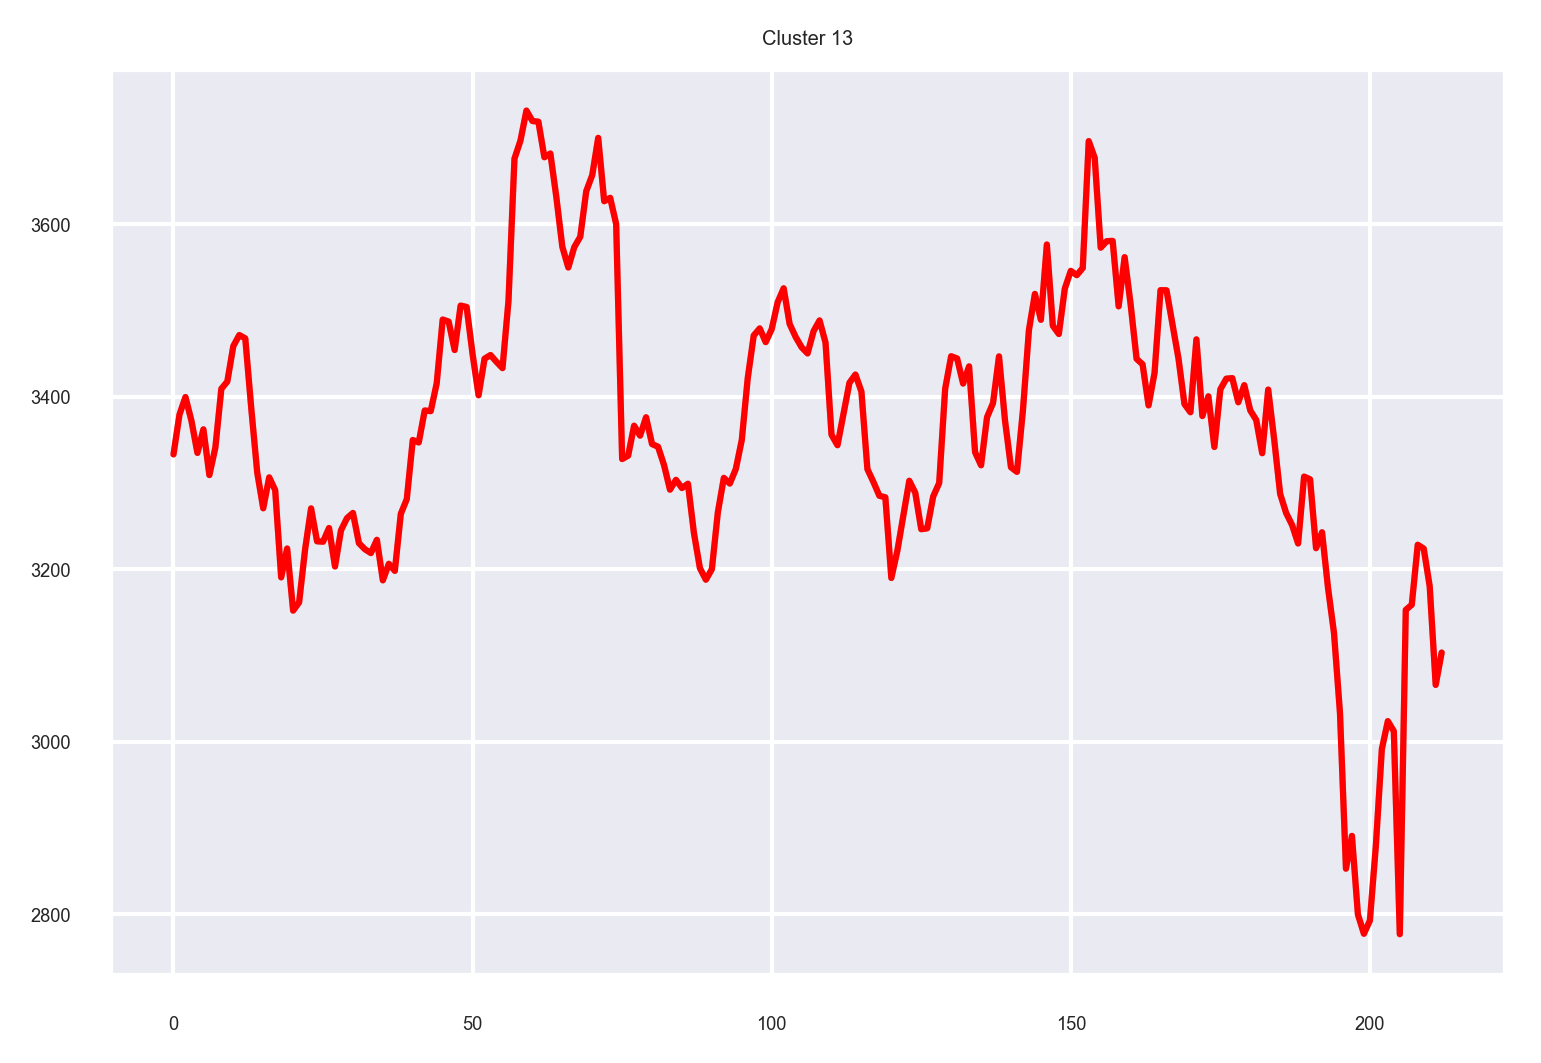

In [95]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
plot_count = math.ceil(math.sqrt(cluster_count))
row_i=0
column_j=0
graphs_dist_by_cluster = []
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
        if(labels[i]==label):
            plt.plot(mySeries[i],c="gray",alpha=0.4)
            cluster.append(mySeries[i])

    avg_graph = np.average(np.vstack(cluster),axis=0)
    if len(cluster) > 0:
        plt.plot(avg_graph,c="red")
    plt.title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
    plt.show()

    graphs_dist = []
    for i in range(len(labels)):
        if(labels[i]==label):
            graphs_dist.append(np.linalg.norm(avg_graph - mySeries[i]))
    graphs_dist_by_cluster.append(graphs_dist)

In [96]:
namesofMySeries = df_union.columns.to_list()


# namesofMySeries

In [97]:
profit = ((df_union.iloc[-1] * 100) / df_union.iloc[0]).to_list()

In [98]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
stocks_clusters = pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).set_index("Series")

stocks_clusters["Dist from avg"] = 0
stocks_clusters["Profit"] = profit
for k in range(cluster_count):
    if len(graphs_dist_by_cluster[k]) == 1:
        stocks_clusters["Dist from avg"][stocks_clusters["Cluster"] == f"Cluster {k}"] = 0.0
    else:
        stocks_clusters["Dist from avg"][stocks_clusters["Cluster"] == f"Cluster {k}"] = graphs_dist_by_cluster[k]
stocks_clusters

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Cluster  Dist from avg      Profit
Series                                      
A       Cluster 4     529.738962  102.455108
AA      Cluster 6     270.157682  221.203959
AAL     Cluster 6     144.876605   77.916851
AAPL    Cluster 4     567.798248  127.910328
AAWW    Cluster 0     156.387651  118.042105
...           ...            ...         ...
ZG      Cluster 0     410.013120   41.176048
ZNH     Cluster 6      37.137519   96.864405
ZNTL    Cluster 0     355.213082  106.487988
ZTO     Cluster 6      24.553121  101.793573
ZTS     Cluster 4     302.821592  120.450080

[647 rows x 3 columns]

In [75]:
x = stocks_clusters.loc[stocks_clusters["Cluster"] == f"Cluster {0}"].drop("Cluster", axis=1)


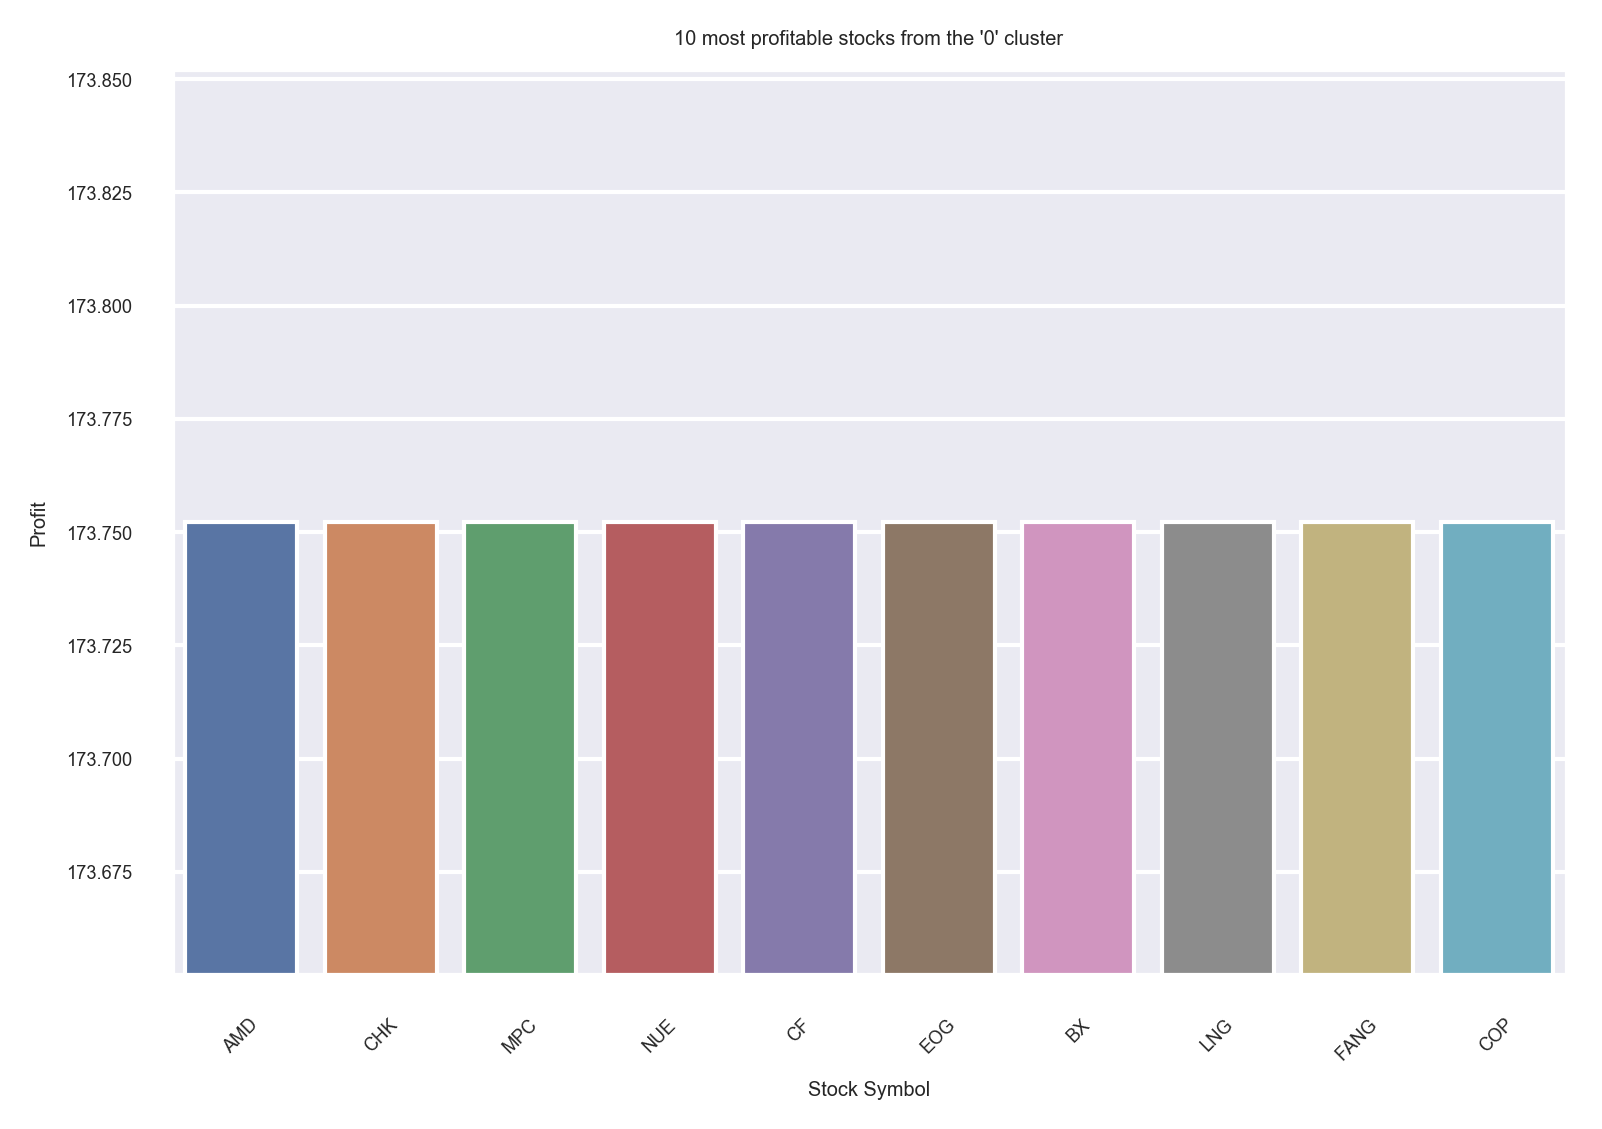

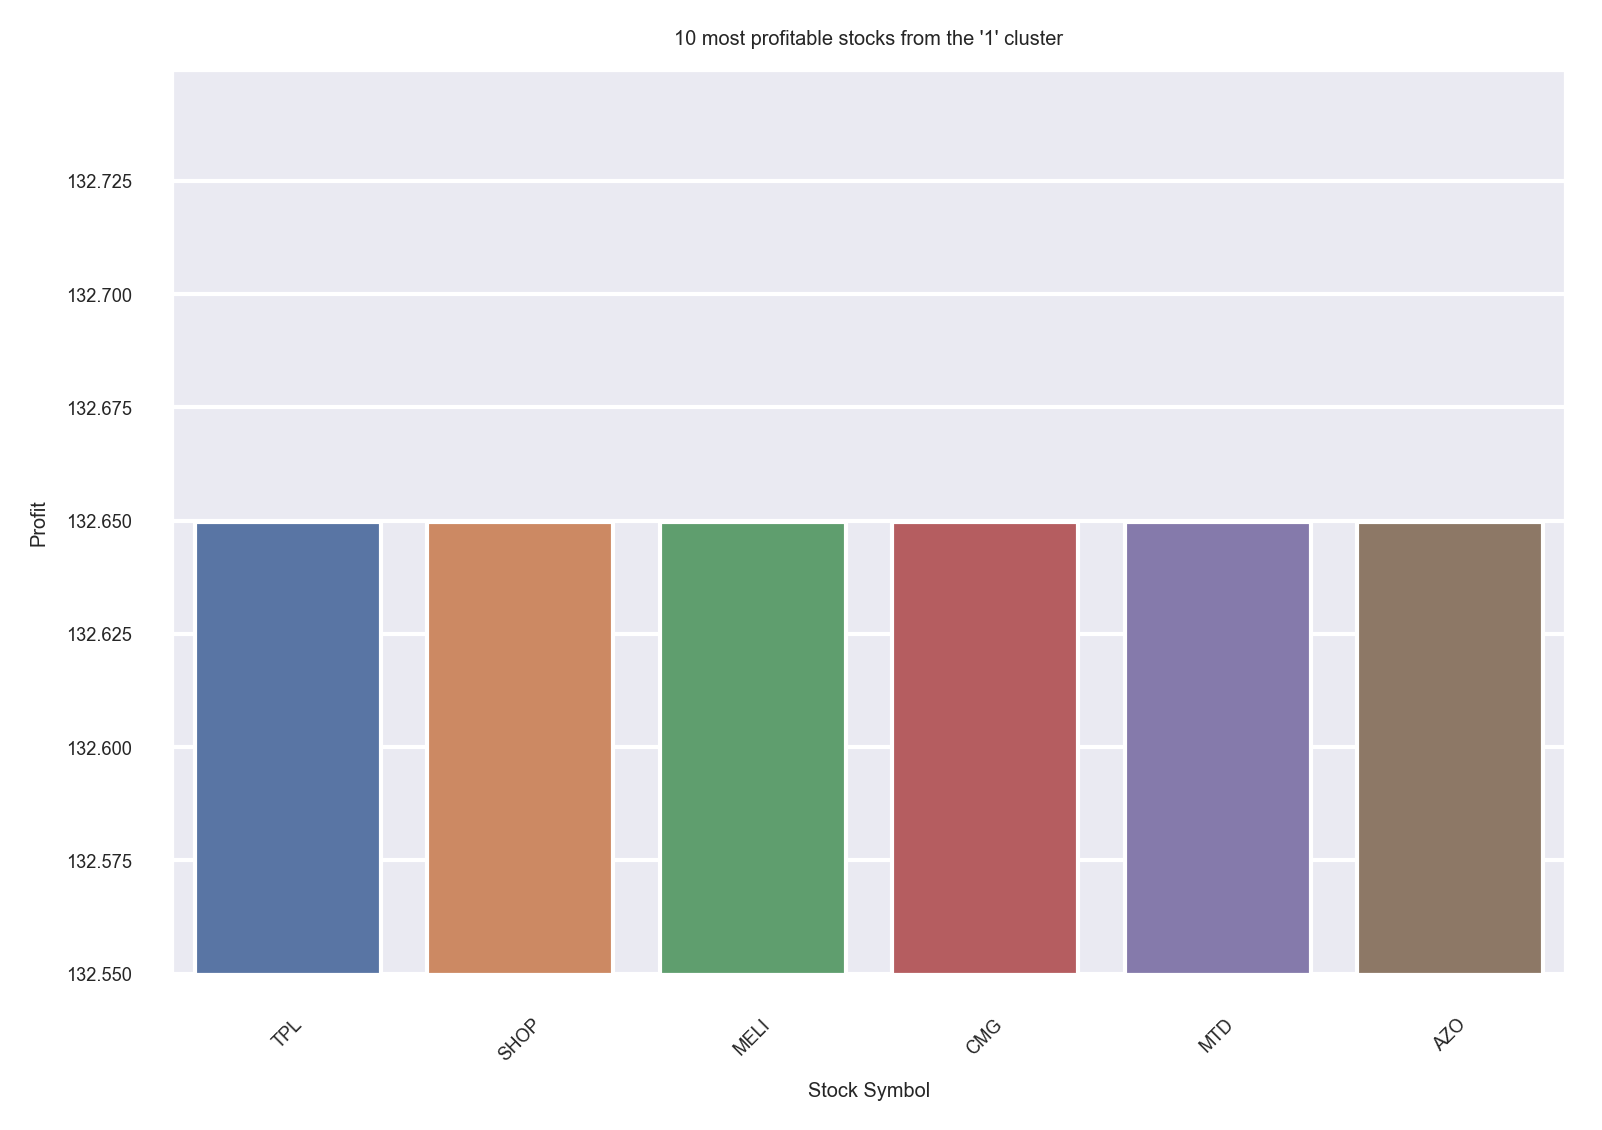

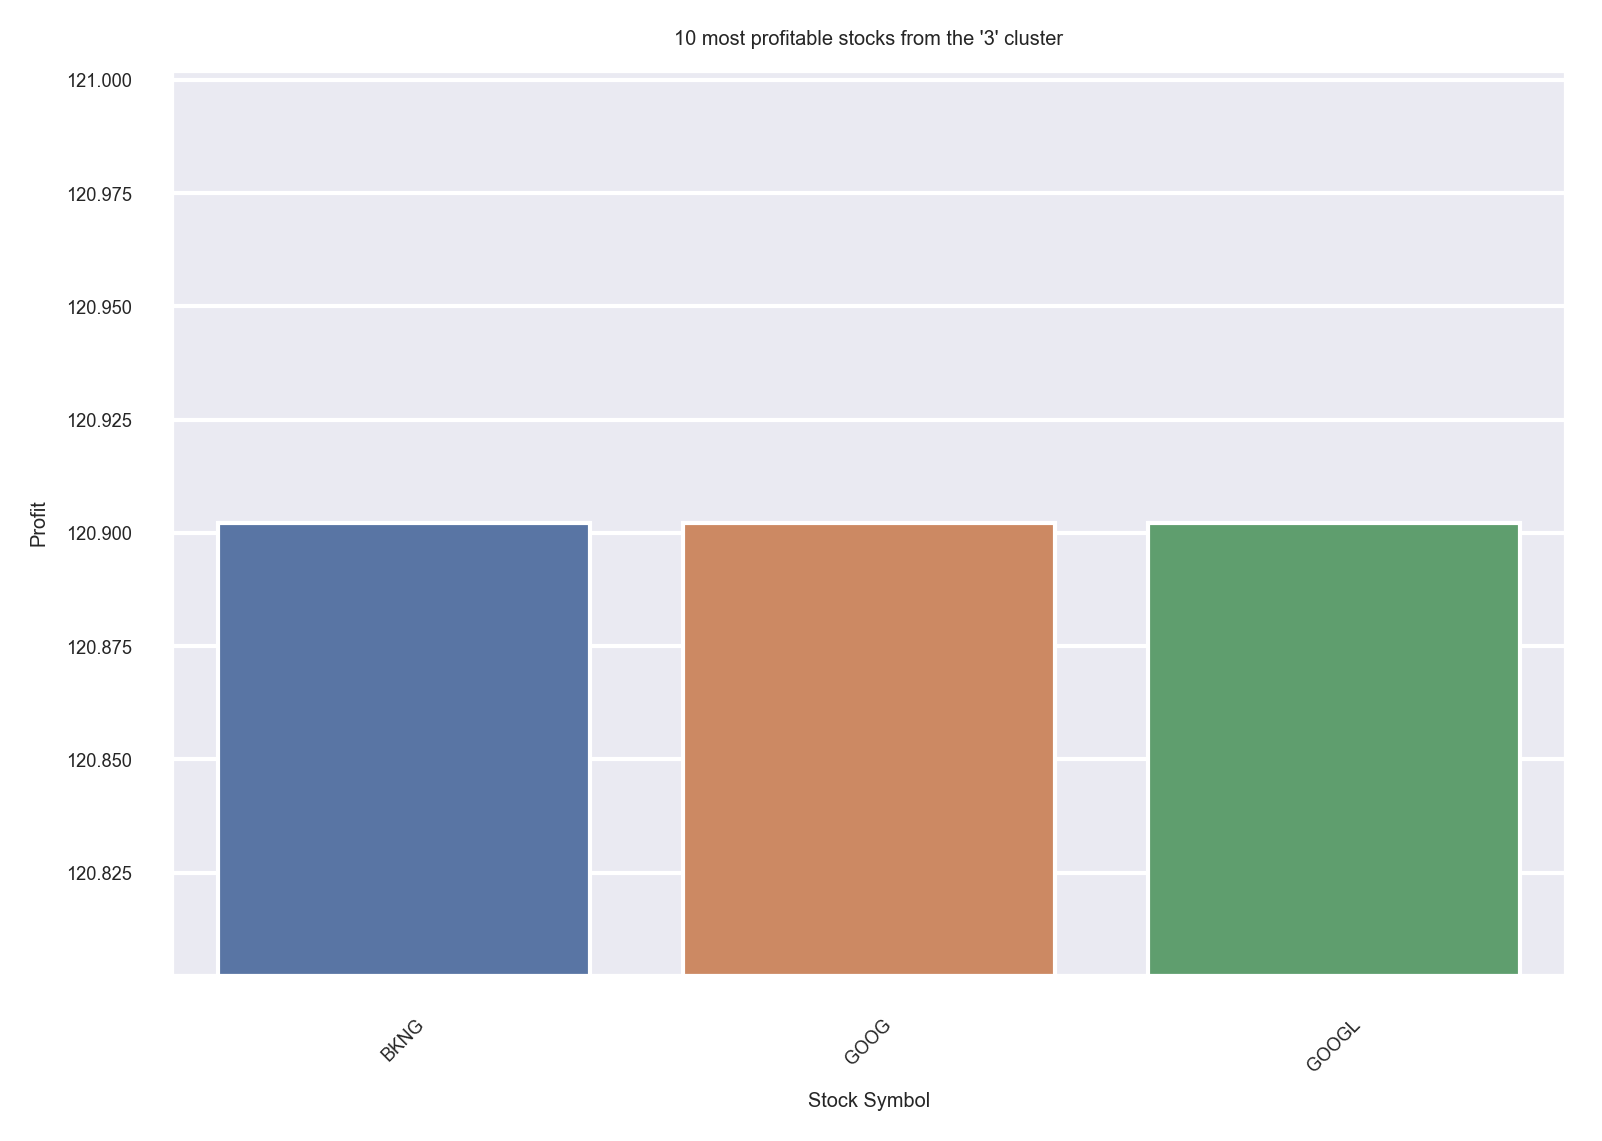

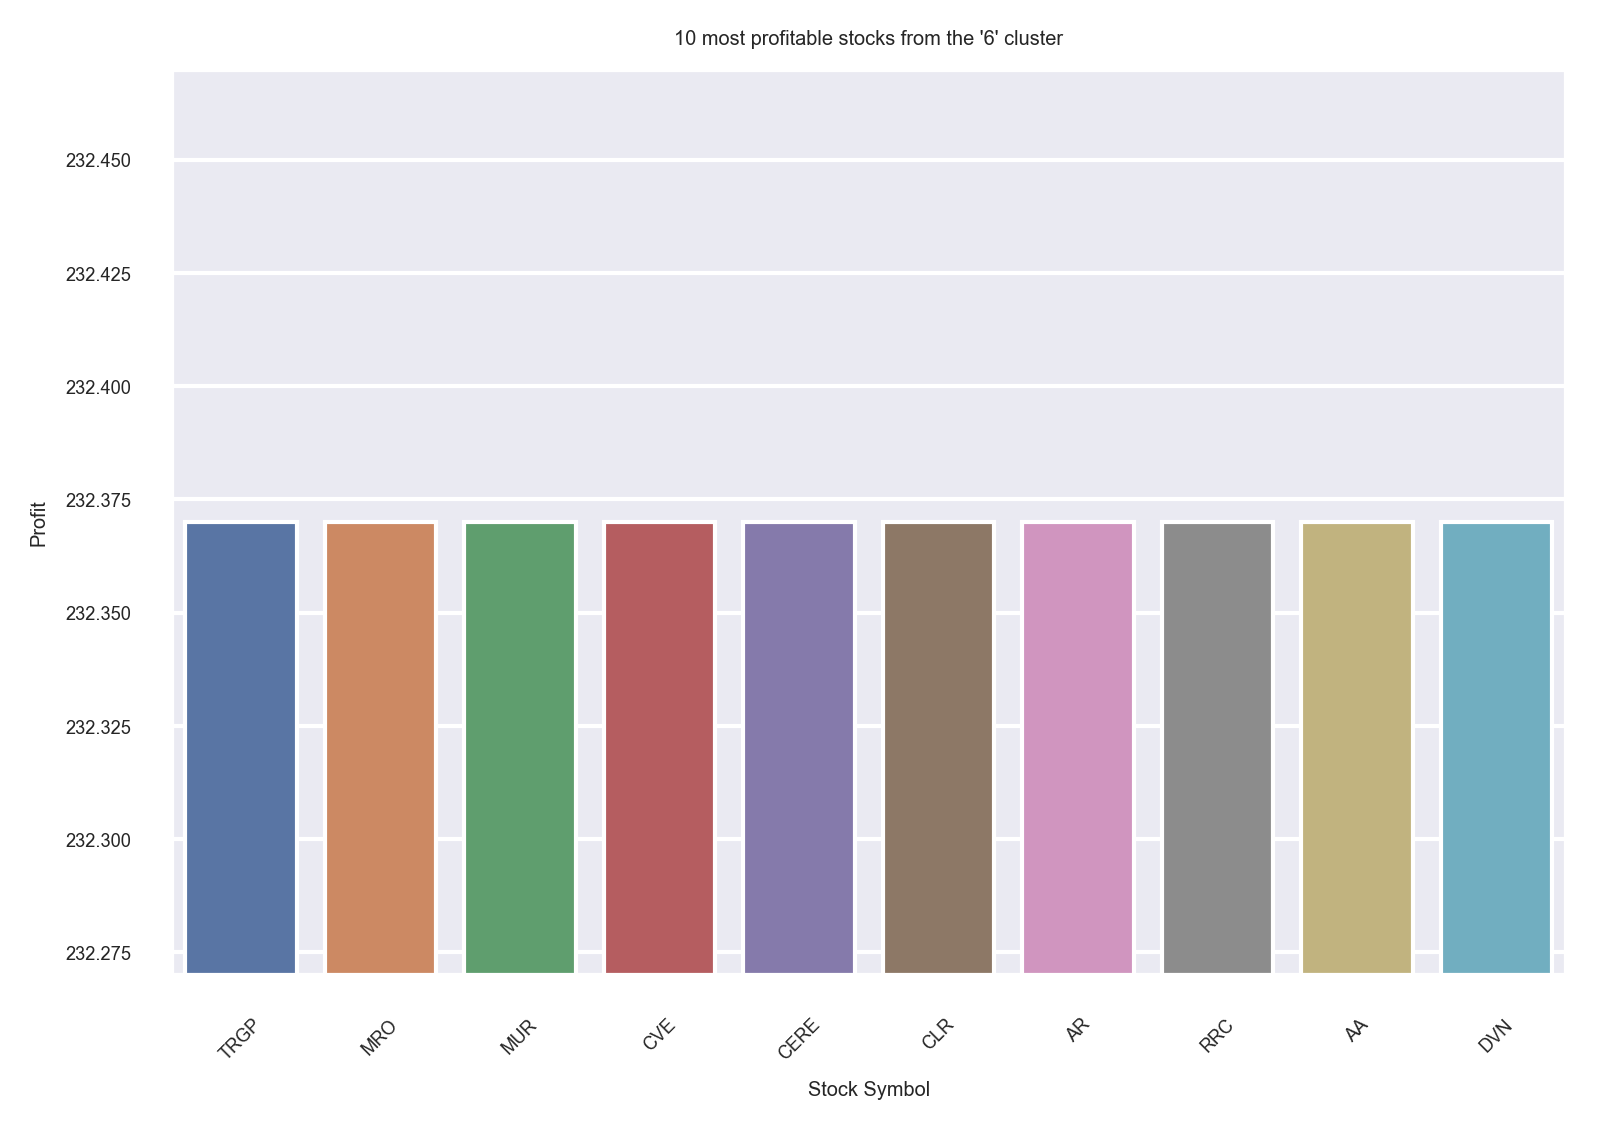

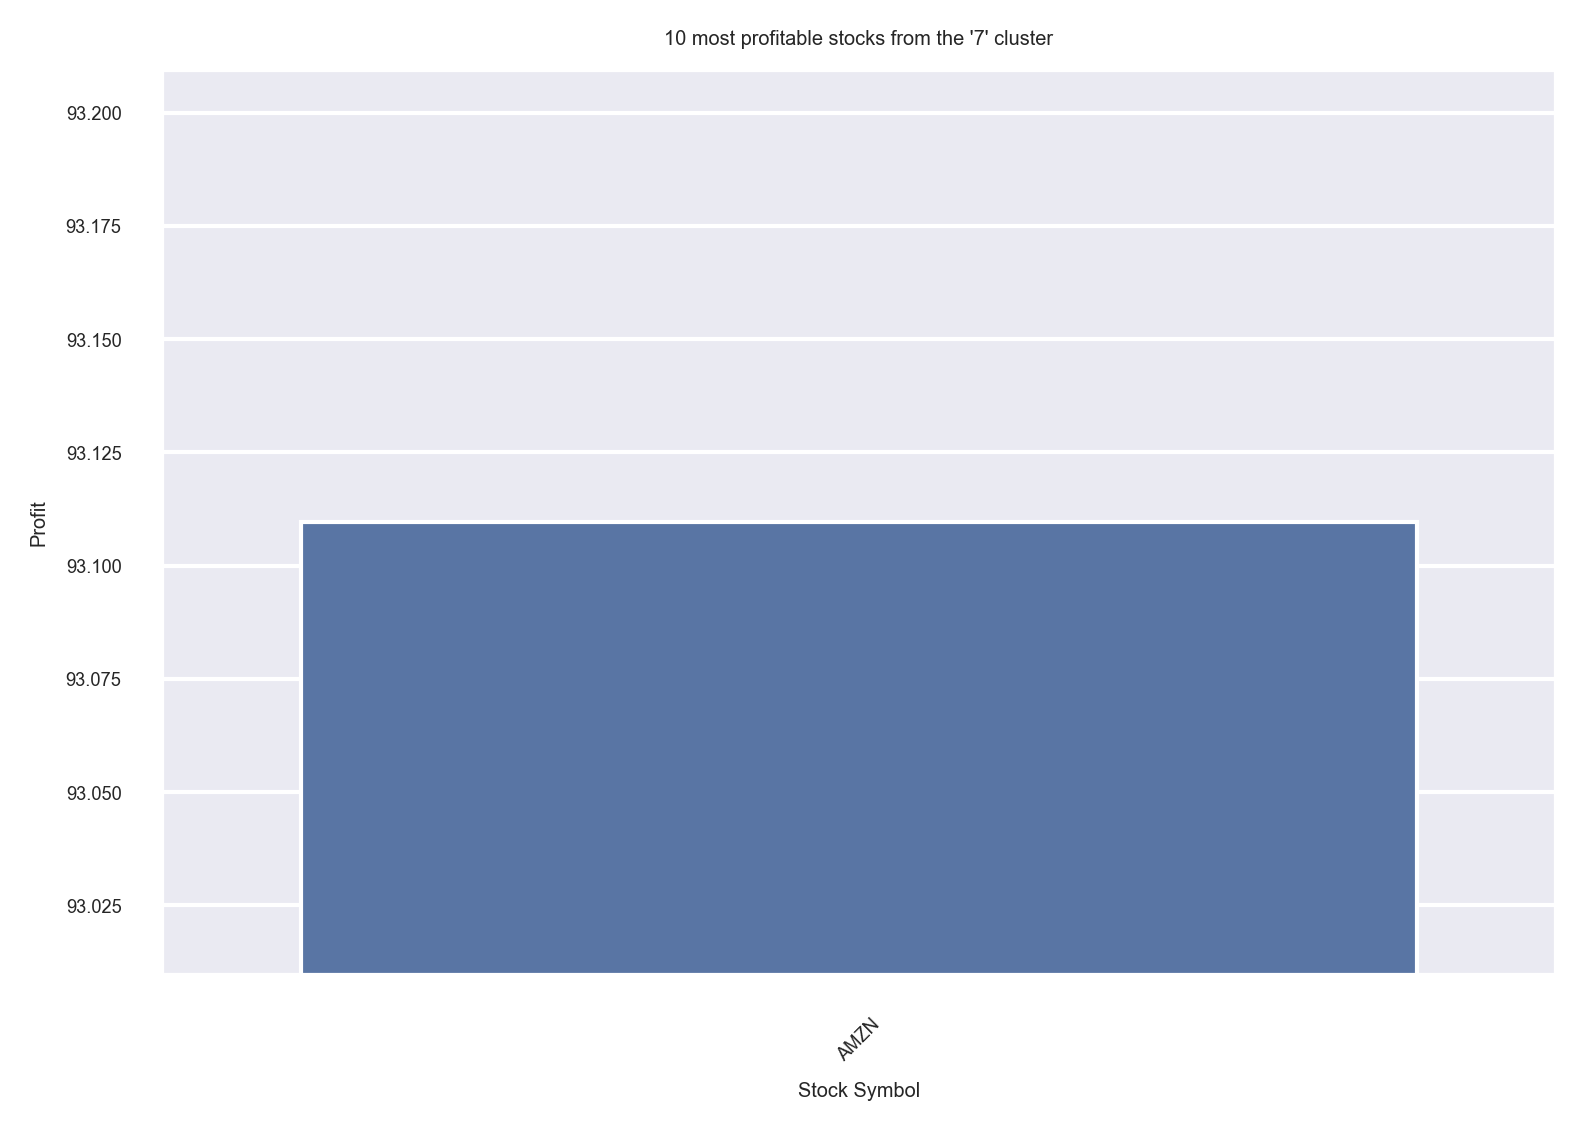

In [133]:
def most_frequent(List):
    return max(set(List), key = List.count)


results, results_score = [], []
for i in range(cluster_count):
    df = stocks_clusters.loc[stocks_clusters["Cluster"] == f"Cluster {i}"].drop("Cluster", axis=1).sort_values(by='Profit')

    if np.max(df["Profit"]) != 0.0:
        df["Profit"] = np.max(df["Profit"])
    if np.max(df["Dist from avg"]) != 0.0:
        df["Dist from avg"] /= -np.max(df["Dist from avg"])
    y_bottom = max(0, min(df["Profit"][-10:])-0.1)
    y_upper = max(df["Profit"][-10:]) + 0.1


    sns.barplot(x=df[-10: ].index.to_list(), y='Profit', data=df[-10:])
    plt.xticks(rotation=45)
    plt.ylim(y_bottom, y_upper)
    plt.title(f"10 most profitable stocks from the \'{i}\' cluster")
    plt.xlabel("Stock Symbol")
    plt.ylabel("Profit")
    # plt.savefig(f"results/{colors[i]}.png")
    plt.show()

    # plt.title(f"Heat map of the 10 most profitable stocks from the \"{colors[i]}\" cluster")
    # generate_heat_map(df_union[df_union.columns.intersection(df[-10: ]["Stock Symbol"].tolist())])

    max_results = []
    max_results_score = []
    for j in range(len(hyper_options)):
        tmp = ((df["Profit"] * hyper_options[j][0]) + (df["Dist from avg"] * hyper_options[j][1])).tolist()
        df[f'{j}'] = tmp
        max_results.append(df[f'{j}'].idxmax())
        # max_results.append(df.loc[df[f'{j}'].idxmax()].index.to_list())
        max_results_score.append(tmp)
    results.append(most_frequent(max_results))
    results_score.append(max_results_score)


In [145]:
print("We recommend to invest in:")
print(len(results_score[0]))

We recommend to invest in:
7


In [146]:
for i in range(K):
    stock_symbol = results[i]
    stock_sector = stocks_screener.loc[stocks_screener["Symbol"] == "AAPL"]["Sector"].values[0]
    print(f'\'{stock_symbol}\' stock from the {stock_sector} sector, with score of {np.round(results_score[i], 3)}, from the \"{i}\" cluster')

'AEE' stock from the Technology sector, with score of [[ -0.73   -0.589  -0.567 ...  -0.303  -0.421  -0.462]
 [173.752 173.752 173.752 ... 173.752 173.752 173.752]
 [ 86.511  86.582  86.593 ...  86.725  86.666  86.645]
 ...
 [130.132 130.167 130.172 ... 130.238 130.209 130.199]
 [ 57.431  57.525  57.54  ...  57.716  57.637  57.61 ]
 [115.592 115.639 115.646 ... 115.734 115.694 115.681]], from the "0" cluster
'MTD' stock from the Technology sector, with score of [[ -0.796  -0.643  -0.619  -0.626  -0.341  -1.   ]
 [132.65  132.65  132.65  132.65  132.65  132.65 ]
 [ 65.927  66.003  66.015  66.012  66.155  65.825]
 [ 32.566  32.68   32.698  32.693  32.907  32.412]
 [ 99.288  99.326  99.332  99.331  99.402  99.237]
 [ 43.686  43.788  43.804  43.799  43.989  43.55 ]
 [ 88.168  88.219  88.227  88.224  88.32   88.1  ]], from the "1" cluster
'SBAC' stock from the Technology sector, with score of [[-6.44000e-01 -4.95000e-01 -6.69000e-01 -4.49000e-01 -2.10000e-01
  -4.39000e-01 -6.34000e-01 -5.6